In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Lorenz System Parameters
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

# Reservoir Computer Parameters
N = 100
P = 0.05
rho_res = 0.6
sigma_in = 0.2
gamma = 10.0
beta_ridge = 1e-4

# Time Parameters
dt = 0.01
t_listen = 100.0
t_train = 100.0
t_predict = 300.0

# Initial Conditions
lorenz_ic = np.array([1.0, 1.0, 1.0])
random_seed = 42


def lorenz_system(u, sigma, rho, beta):
    x, y, z = u
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])


def reservoir_dynamics(r, u, M, W_in, gamma, sigma_in):
    internal_state = M @ r + sigma_in * W_in @ u
    dr_dt = gamma * (-r + np.tanh(internal_state))
    return dr_dt


def rk4_integrator(dynamics_func, state, dt, *args):
    k1 = dynamics_func(state, *args)
    k2 = dynamics_func(state + 0.5 * dt * k1, *args)
    k3 = dynamics_func(state + 0.5 * dt * k2, *args)
    k4 = dynamics_func(state + dt * k3, *args)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state


def generate_reservoir_matrices(N, P, rho_res, seed=None):
    if seed is not None:
        np.random.seed(seed)

    connections = np.random.rand(N, N) < P
    M = np.random.uniform(-1, 1, (N, N)) * connections

    eigenvals = np.linalg.eigvals(M)
    current_rho = np.max(np.abs(eigenvals))
    if current_rho > 0:
        M = M * (rho_res / current_rho)

    W_in = np.zeros((N, 3))
    for i in range(N):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)

    return M, W_in


def state_augmentation(r):
    return np.concatenate([r, r**2])


def ridge_regression(X, Y, beta_ridge):
    XXT = X @ X.T
    reg_matrix = XXT + beta_ridge * np.eye(XXT.shape[0])
    W_out = Y @ X.T @ np.linalg.inv(reg_matrix)
    return W_out


def generate_lorenz_data(total_time, dt, initial_condition):
    num_steps = int(total_time / dt)
    u_series = np.zeros((3, num_steps))
    u_current = initial_condition.copy()

    for i in range(num_steps):
        u_series[:, i] = u_current #state at time step i or old state that is input to integration
        u_current = rk4_integrator(lorenz_system, u_current, dt, sigma, rho, beta) #new state after integration

    return u_series, np.arange(0, total_time, dt)


def listening_phase(u_series, M, W_in, t_listen, dt):
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N)

    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)
    return r_current


def training_phase(u_series, r_initial, M, W_in, t_listen, t_train, dt):
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)

    X = np.zeros((2*N, num_train_steps))
    Y = np.zeros((3, num_train_steps))
    r_current = r_initial.copy()

    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]

        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input

        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)
    return W_out, r_current


def prediction_phase(r_initial, M, W_in, W_out, t_predict, dt):
    num_predict_steps = int(t_predict / dt)
    u_pred = np.zeros((3, num_predict_steps))
    r_series = np.zeros((N, num_predict_steps))
    r_current = r_initial.copy()

    for i in range(num_predict_steps):
        r_series[:, i] = r_current
        q_current = state_augmentation(r_current)
        u_hat = W_out @ q_current
        u_pred[:, i] = u_hat
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_hat, M, W_in, gamma, sigma_in)

    return u_pred, r_series


def analyze_reconstruction(u_true, u_pred, t_predict, dt):
    num_predict_steps = int(t_predict / dt)
    pred_error = np.mean(np.linalg.norm(u_true[:, :num_predict_steps] - u_pred, axis=0))
    short_steps = min(int(50 / dt), num_predict_steps)
    short_error = np.mean(np.linalg.norm(u_true[:, :short_steps] - u_pred[:, :short_steps], axis=0))

    return {
        'overall_error': pred_error,
        'short_term_error': short_error,
        'success': short_error < 1.0
    }


def visualize_results(u_true, u_pred, t_listen, t_train, t_predict, dt):
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)
    num_predict_steps = int(t_predict / dt)

    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps

    fig = plt.figure(figsize=(18, 12))

    ax1 = fig.add_subplot(231, projection='3d')
    ax1.plot(u_true[0, train_start:train_end],
             u_true[1, train_start:train_end],
             u_true[2, train_start:train_end],
             'red', alpha=0.8, linewidth=1.5, label='True Lorenz')
    ax1.set_title('Training Phase: True Lorenz Attractor', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    ax2 = fig.add_subplot(232, projection='3d')
    ax2.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :],
             'darkblue', alpha=0.8, linewidth=1.5, label='Reconstructed')
    ax2.set_title('Prediction Phase: Reconstructed Attractor', fontsize=12)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()

    ax3 = fig.add_subplot(233, projection='3d')
    ax3.plot(u_true[0, train_start:train_end],
             u_true[1, train_start:train_end],
             u_true[2, train_start:train_end],
             'red', alpha=0.6, linewidth=1.5, label='True Lorenz')
    ax3.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :],
             'darkblue', alpha=0.7, linewidth=1.5, label='Reconstructed')
    ax3.set_title('True vs Reconstructed Overlay', fontsize=12)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()

    ax4 = fig.add_subplot(234)
    short_steps = min(500, num_predict_steps)
    t_short = np.arange(short_steps) * dt

    if u_true.shape[1] > train_end + short_steps:
        pred_start = train_end
        ax4.plot(t_short, u_true[0, pred_start:pred_start+short_steps],
                 'red', linewidth=2, label='True X', alpha=0.8)

    ax4.plot(t_short, u_pred[0, :short_steps],
             'darkblue', linewidth=2, label='Reconstructed X', alpha=0.8)

    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('X coordinate')
    ax4.set_title(f'Short-term Comparison (first {short_steps*dt:.1f}s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(235)
    t_pred = np.arange(num_predict_steps) * dt

    ax5.plot(t_pred, u_pred[0, :], 'darkblue',
             linewidth=1, label='Reconstructed X', alpha=0.8)

    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('X coordinate')
    ax5.set_title(f'Long-term Reconstruction ({t_predict:.1f}s)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    ax6 = fig.add_subplot(236, projection='3d')
    ax6.plot(u_true[0, train_start:train_end],
             u_true[1, train_start:train_end],
             u_true[2, train_start:train_end],
             'red', alpha=0.7, linewidth=1.5, label='True Lorenz')
    ax6.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :],
             'darkblue', alpha=0.7, linewidth=1.5, label='Reconstructed')
    ax6.set_title('True vs Reconstructed Overlay', fontsize=12)
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_zlabel('Z')
    ax6.legend()


def plot_spectral_analysis(M, rho_res):
    eigenvals = np.linalg.eigvals(M)
    actual_rho = np.max(np.abs(eigenvals))

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.scatter(eigenvals.real, eigenvals.imag, c='darkgreen', alpha=0.6, s=20,
               label=f'Eigenvalues (N={len(eigenvals)})')

    theta = np.linspace(0, 2*np.pi, 100)
    target_circle_real = rho_res * np.cos(theta)
    target_circle_imag = rho_res * np.sin(theta)
    ax.plot(target_circle_real, target_circle_imag, 'r--', linewidth=2,
            label=f'Target ρ = {rho_res}')

    actual_circle_real = actual_rho * np.cos(theta)
    actual_circle_imag = actual_rho * np.sin(theta)
    ax.plot(actual_circle_real, actual_circle_imag, 'b-', linewidth=2,
            label=f'Actual ρ = {actual_rho:.4f}')

    ax.plot(np.cos(theta), np.sin(theta), 'k:', linewidth=1, alpha=0.5,
            label='Unit Circle')

    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Reservoir Matrix Spectral Analysis')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    textstr = f'''Spectral Statistics:
Target ρ: {rho_res}
Actual ρ: {actual_rho:.4f}
Matrix Size: {M.shape[0]}×{M.shape[1]}
Sparsity: {P:.1%}
Non-zero Elements: {np.count_nonzero(M)}'''

    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()


def main():
    """Run single Lorenz attractor reconstruction experiment"""
    print("Lorenz Attractor Reconstruction using Reservoir Computing")
    print("=" * 70)

    np.random.seed(random_seed)

    M, W_in = generate_reservoir_matrices(N, P, rho_res, random_seed)
    total_time = t_listen + t_train + t_predict
    u_series, time_array = generate_lorenz_data(total_time, dt, lorenz_ic)

    r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)
    W_out, r_after_training = training_phase(u_series, r_after_listening,
                                            M, W_in, t_listen, t_train, dt)
    u_pred, r_series = prediction_phase(r_after_training, M, W_in, W_out,
                                       t_predict, dt)
    analysis_results = analyze_reconstruction(u_series, u_pred, t_predict, dt)

    visualize_results(u_series, u_pred, t_listen, t_train, t_predict, dt)
    plot_spectral_analysis(M, rho_res)

    print(f"\nReconstruction Results:")
    print(f"Overall RMSE: {analysis_results['overall_error']:.6f}")
    print(f"Short-term RMSE: {analysis_results['short_term_error']:.6f}")
    print(f"Success: {'✓' if analysis_results['success'] else '✗'}")

    return {
        'u_series': u_series,
        'u_pred': u_pred,
        'r_series': r_series,
        'W_out': W_out,
        'M': M,
        'W_in': W_in,
        'analysis': analysis_results
    }


In [2]:
def create_input_weights(N_local, seed=42):
    """Create input weight matrix W_in - separate from topology creation"""
    np.random.seed(seed)
    print(f"    Creating input weights with seed {seed}")

    W_in = np.zeros((N_local, 3))
    for i in range(N_local):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)

    print(f"    ✓ Input weights created: {W_in.shape}")
    return W_in


def create_random_matrix(N_local, P, matrix_seed):
    """Create random reservoir matrix M - isolated from input weights"""
    np.random.seed(matrix_seed)
    print(f"    Creating matrix with seed {matrix_seed}")

    connectivity_mask = np.random.rand(N_local, N_local) < P
    random_weights = np.random.uniform(-1, 1, (N_local, N_local))
    M_base = random_weights * connectivity_mask

    # Enhanced zero matrix handling
    if np.max(np.abs(M_base)) == 0:
        print(f"      WARNING: Zero matrix detected! Adding forced connections...")
        num_forced_connections = max(5, N_local // 10)
        for _ in range(num_forced_connections):
            i, j = np.random.randint(0, N_local, 2)
            M_base[i, j] = np.random.uniform(-1, 1)
        print(f"      Added {num_forced_connections} forced connections")

        # Double-check after adding connections
        if np.max(np.abs(M_base)) == 0:
            print(f"      ERROR: Still zero matrix after forced connections!")
            for i in range(min(5, N_local)):
                for j in range(min(5, N_local)):
                    if i != j:
                        M_base[i, j] = np.random.uniform(-1, 1)
            print(f"      Created minimal working matrix")

    matrix_stats = {
        'seed': matrix_seed,
        'total_connections': np.count_nonzero(M_base),
        'sparsity': np.count_nonzero(M_base) / (N_local * N_local),
        'max_weight': np.max(np.abs(M_base))
    }

    print(f"      Connections: {matrix_stats['total_connections']}")
    print(f"      Sparsity: {matrix_stats['sparsity']:.3f}")
    print(f"      Max weight: {matrix_stats['max_weight']:.3f}")

    return M_base, matrix_stats


def scale_matrix_to_spectral_radius(M_base, target_rho):
    """Scale matrix to target spectral radius - handles rho=0 case"""

    # Special case: if target is 0, return zero matrix
    if target_rho == 0.0:
        print(f"        Target ρ = 0: Creating zero matrix for untrained attractor analysis")
        M_scaled = np.zeros_like(M_base) #Creates array of zeros with same shape and dtype as M_base
        return M_scaled, 0.0, 0.0 # Returns tuple: (scaled_matrix, achieved_spectral_radius, scaling_factor)

    eigenvals = np.linalg.eigvals(M_base)
    current_rho = np.max(np.abs(eigenvals))

    if current_rho == 0:
        print(f"        ERROR: Cannot scale zero matrix to non-zero ρ! Current ρ = 0")
        return M_base, 0, 0

    if current_rho < 1e-10:
        print(f"        WARNING: Very small spectral radius {current_rho:.2e}, may cause numerical issues")

    scaling_factor = target_rho / current_rho
    M_scaled = M_base * scaling_factor

    # Verify scaling worked
    eigenvals_scaled = np.linalg.eigvals(M_scaled)
    achieved_rho = np.max(np.abs(eigenvals_scaled))

    scaling_error = abs(achieved_rho - target_rho) / target_rho if target_rho > 0 else 0
    if scaling_error > 0.01:
        print(f"        WARNING: Scaling error {scaling_error:.3f}")

    return M_scaled, achieved_rho, scaling_factor


def run_single_matrix_experiment(M, W_in, N_val, matrix_idx, rho_val,t_predict=500.0):
    """Run single experiment for matrix analysis"""
    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)

    N_local = M.shape[0]
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)

    # Listening phase
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase
    num_train_steps = int(t_train / dt)
    X = np.zeros((2*N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))

    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]

        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input

        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase
    longer_predict_time = t_predict
    num_predict_steps = int(longer_predict_time / dt)
    u_pred = np.zeros((3, num_predict_steps))

    for i in range(num_predict_steps):
        q_current = state_augmentation(r_current)
        u_hat = W_out @ q_current
        u_pred[:, i] = u_hat
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_hat, M, W_in, gamma, sigma_in)

    # Simple performance calculation
    Y_train_pred = W_out @ X
    train_rmse = np.mean(np.linalg.norm(Y - Y_train_pred, axis=0))

    return {
        'u_pred': u_pred,
        'train_rmse': train_rmse,
        'matrix_idx': matrix_idx,
        'rho': rho_val,
        'N': N_val
    }


def matrix_realisation_analysis(N_val=100, num_matrices=10, rho_values=[0.0, 0.1, 0.6, 0.9, 1.2, 1.5], t_predict=500.0, base_seed=42):
    """Analyze different matrix realisations across spectral radii"""
    print(f"Running matrix realisation analysis: {num_matrices} matrices × {len(rho_values)} spectral radii")

    # Create single shared input weight matrix for all experiments
    shared_W_in = create_input_weights(N_val, seed=base_seed + 1000)
    print(f"✓ Created shared input weights for all matrices")

    all_results = {}
    all_matrices = {}

    # Generate different matrix realisations
    for matrix_idx in range(num_matrices):
        matrix_seed = base_seed + matrix_idx * 12345
        M_base, matrix_stats = create_random_matrix(N_val, P, matrix_seed)

        all_matrices[matrix_idx] = {
            'M_base': M_base,
            'stats': matrix_stats,
            'seed': matrix_seed
        }

    experiment_count = 0
    total_experiments = num_matrices * len(rho_values)

    # Run experiments for each matrix-rho combination
    for matrix_idx in range(num_matrices):
        M_base = all_matrices[matrix_idx]['M_base']

        for rho_val in rho_values:
            experiment_count += 1
            print(f"Experiment {experiment_count}/{total_experiments}: Matrix {matrix_idx}, ρ = {rho_val}")

            M_scaled, achieved_rho, scaling_factor = scale_matrix_to_spectral_radius(M_base, rho_val)

            results = run_single_matrix_experiment(M_scaled, shared_W_in, N_val, matrix_idx, rho_val, t_predict)

            key = f"M{matrix_idx}_R{rho_val}"
            all_results[key] = results
            all_results[key]['achieved_rho'] = achieved_rho
            all_results[key]['scaling_factor'] = scaling_factor

    return all_results, all_matrices, shared_W_in


def plot_matrix_realisation_grid(all_results, all_matrices, N_val, num_matrices, rho_values):
    """Visualize matrix realisation analysis results"""
    fig_width = 4 * len(rho_values)
    fig_height = 3 * num_matrices
    fig = plt.figure(figsize=(fig_width, fig_height))

    fig.suptitle(f'Matrix Realisation Analysis: Different Matrices vs Spectral Radius (N={N_val})',
                fontsize=16, y=0.98)

    subplot_idx = 1

    for matrix_idx in range(num_matrices):
        for col_idx, rho_val in enumerate(rho_values):
            key = f"M{matrix_idx}_R{rho_val}"

            ax = fig.add_subplot(num_matrices, len(rho_values), subplot_idx, projection='3d')

            if key in all_results:
                results = all_results[key]
                u_pred = results['u_pred']
                rmse = results['train_rmse']

                ax.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :],
                       'darkblue', alpha=0.8, linewidth=1.0)

                # Simple title with RMSE
                title = f'RMSE: {rmse:.3f}'
                title_color = 'black'

            else:
                ax.text(0.5, 0.5, 0.5, 'No Data', transform=ax.transAxes,
                       ha='center', va='center', fontsize=12)
                title_color, title = 'gray', 'Missing'

            ax.set_xlim([-25, 25])
            ax.set_ylim([-35, 35])
            ax.set_zlim([0, 50])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_title(title, fontsize=10, color=title_color, weight='bold')

            # Row labels
            if col_idx == 0:
                matrix_stats = all_matrices[matrix_idx]['stats']
                connections = matrix_stats['total_connections']
                sparsity = matrix_stats['sparsity']

                row_label = f'Matrix {matrix_idx}\n{connections} conn.\n{sparsity:.2f} sparse'
                ax.text2D(-0.2, 0.5, row_label, transform=ax.transAxes,
                         rotation=90, verticalalignment='center',
                         fontsize=9, weight='bold', ha='center')

            # Column headers
            if matrix_idx == 0:
                ax.text2D(0.5, 1.2, f'ρ = {rho_val}', transform=ax.transAxes,
                         horizontalalignment='center', fontsize=12, weight='bold')

            subplot_idx += 1

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def run_matrix_realisation_experiment(N_val=100, num_matrices=10, rho_values=[0.0, 0.1, 0.6, 0.9, 1.2, 1.5],t_predict=500.0):
    """Complete matrix realisation analysis experiment"""
    print("Matrix Realisation Analysis Experiment")
    print("=" * 50)

    all_results, all_matrices, shared_W_in = matrix_realisation_analysis(
        N_val=N_val,
        num_matrices=num_matrices,
        rho_values=rho_values
    )

    plot_matrix_realisation_grid(all_results, all_matrices, N_val, num_matrices, rho_values)

    print(f"\nMatrix Realisation Analysis Complete")
    print(f"Successful experiments: {len(all_results)}/{num_matrices * len(rho_values)}")

    return all_results, all_matrices, shared_W_in


In [3]:
def generate_random_initial_conditions(N_local, num_conditions=10, seed=42):
    """Generate random initial conditions for reservoir states"""
    np.random.seed(seed)
    print(f"    Generating {num_conditions} random initial conditions (seed: {seed})")

    ric = []
    for i in range(num_conditions):
        random_state = np.random.uniform(-1, 1, N_local)
        ric.append(random_state)

    sample_state = ric[0]
    print(f"    ✓ Generated {len(ric)} initial conditions")
    print(f"    ✓ State dimension: {N_local}")
    print(f"    ✓ Value range: [{np.min(sample_state):.3f}, {np.max(sample_state):.3f}]")

    return ric


#Runs one complete reservoir computing experiment using multiple initial conditions with the same trained readout weights

def run_single_ic_experiment(M, W_in, ric, N_val, matrix_idx, rho_val, t_predict):
    """Run single experiment with multiple initial conditions"""
    print(f"      Running experiment: Matrix {matrix_idx}, ρ = {rho_val}")

    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)

    N_local = M.shape[0]

    # Listening phase
    print(f"        Phase 1: Listening ({t_listen}s)")
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)

    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase
    print(f"        Phase 2: Training ({t_train}s)")
    num_train_steps = int(t_train / dt)
    X = np.zeros((2*N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))

    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]

        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input

        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase with multiple initial conditions
    print(f"        Phase 3: Prediction with {len(ric)} initial conditions ({t_predict}s)")
    num_predict_steps = int(t_predict / dt)
    all_u_pred = [] ## Store predictions from all initial conditions

    for ic_idx, initial_state in enumerate(ric): # Loop through each IC
        u_pred = np.zeros((3, num_predict_steps)) # Storage for this IC
        r_current = np.array(initial_state) #Start from this IC

        for j in range(num_predict_steps):
            q_current = state_augmentation(r_current)
            u_hat = W_out @ q_current # Predict using learned weights
            u_pred[:, j] = u_hat

            r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                     u_hat, M, W_in, gamma, sigma_in)

        all_u_pred.append(u_pred) #List of num_conditions arrays, each shape (3, num_predict_steps)
    
    # Convert list to 3D numpy array for all_u_pred
    all_u_pred_3d = np.array(all_u_pred)  # Shape: (num_conditions, 3, num_predict_steps)
    
    # Save u_pred in 3D structure
    M_label = matrix_idx  
    sigma_val = sigma_in
    filename_u_pred = f'_u_pred__M_label_{M_label}_rho_{rho_val}_sigma_{sigma_val}_Week7_.npy'
    np.save(filename_u_pred, all_u_pred_3d)
    print(f"        ✓ Saved u_pred data: {filename_u_pred} (shape: {all_u_pred_3d.shape})")
    
    # Save M matrix
    filename_M = f'saving_M_label_{M_label}_Week7_.npy'
    np.save(filename_M, M)
    print(f"        ✓ Saved M matrix: {filename_M} (shape: {M.shape})")

    return {
        'all_u_pred': all_u_pred,
        'matrix_idx': matrix_idx,
        'rho': rho_val,
        'N': N_val
    }
  


def multiple_ic_analysis(N_val=100, num_matrices=10, rho_values=[0.0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
                        num_conditions=10, t_predict=100, base_seed=42):
    """Analyze multiple initial conditions across matrix-spectral radius grid"""
    print(f"Multiple Initial Conditions Analysis")
    print(f"Configuration: {num_matrices} matrices × {len(rho_values)} spectral radii")
    print(f"Initial conditions per experiment: {num_conditions}")
    print(f"Prediction time: {t_predict}s")

    # Create single shared input weight matrix for all experiments
    shared_W_in = create_input_weights(N_val, seed=base_seed + 1000)
    print(f"✓ Created shared input weights for all matrices")

    # Save the shared W_in once (not per experiment)
    np.save('saving_W_shared_Week7_.npy', shared_W_in)
    print(f"✓ Saved shared W_in matrix: saving_W_shared_Week7_.npy")

    all_results = {}
    all_matrices = {}

    print(f"\nStep 1: Generating {num_matrices} matrix realisations...")
    print("-" * 50)

    # Generate shared initial conditions and matrices
    shared_ric = generate_random_initial_conditions(N_val, num_conditions, seed=base_seed + 5000)

    for matrix_idx in range(num_matrices):
        print(f"  Matrix {matrix_idx + 1}/{num_matrices}")
        matrix_seed = base_seed + matrix_idx * 12345
        M_base, matrix_stats = create_random_matrix(N_val, P, matrix_seed)

        all_matrices[matrix_idx] = {
            'M_base': M_base,
            'stats': matrix_stats,
            'seed': matrix_seed
        }

    print(f"\nStep 2: Running {num_matrices * len(rho_values)} experiments...")
    print("-" * 50)

    # Run experiments
    experiment_count = 0
    total_experiments = num_matrices * len(rho_values)

    for matrix_idx in range(num_matrices):
        print(f"\n  Matrix {matrix_idx}: Testing across {len(rho_values)} spectral radii")
        M_base = all_matrices[matrix_idx]['M_base']

        for rho_val in rho_values:
            experiment_count += 1
            print(f"    Experiment {experiment_count}/{total_experiments}: ρ = {rho_val}")

            M_scaled, achieved_rho, scaling_factor = scale_matrix_to_spectral_radius(M_base, rho_val)

            # Don't skip rho=0 case anymore
            results = run_single_ic_experiment(M_scaled, shared_W_in, shared_ric, N_val, matrix_idx, rho_val, t_predict)

            key = f"M{matrix_idx}_R{rho_val}"
            all_results[key] = results
            all_results[key]['achieved_rho'] = achieved_rho

    print(f"\nExperiment completed!")
    print(f"Successful experiments: {len(all_results)}/{total_experiments}")

    return all_results, all_matrices, shared_W_in, shared_ric


def plot_multiple_ic_grid(all_results, all_matrices, N_val, num_matrices, rho_values):
    """Visualize multiple initial conditions grid"""
    fig_width = 6 * len(rho_values) # 6 inches per column
    fig_height = 6 * num_matrices # 6 inches per row
    fig = plt.figure(figsize=(fig_width, fig_height))

    fig.suptitle(f'Multiple Initial Conditions Analysis (N={N_val})\n' +
                f'Rows = Different Matrices, Columns = Different Spectral Radii',
                fontsize=16, y=0.98)

    # Create color palette
    colors = plt.cm.tab10(np.linspace(0, 1, 10)) # 10 distinct colors

    subplot_idx = 1

    for matrix_idx in range(num_matrices): #rows
        for col_idx, rho_val in enumerate(rho_values): #columns
            # Plot trajectories from all initial conditions
            key = f"M{matrix_idx}_R{rho_val}"

            ax = fig.add_subplot(num_matrices, len(rho_values), subplot_idx)

            if key in all_results:
                results = all_results[key]
                all_u_pred = results['all_u_pred']

                # Plot trajectories
                for i, u_pred in enumerate(all_u_pred):
                    color_idx = i % len(colors)
                    color = colors[color_idx]

                    ax.plot(u_pred[0, :], u_pred[2, :],
                           color=color, alpha=0.8, linewidth=1.0) # x-z projection

                title = f'ρ = {rho_val}'
                title_color = 'black'

            else:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes,
                       ha='center', va='center', fontsize=10)
                title_color, title = 'gray', f'ρ = {rho_val}'

            ax.set_xlim([-40, 40])
            ax.set_ylim([-150, 150])
            ax.autoscale(False)

            ax.set_xlabel('x₁(t)', fontsize=10)
            ax.set_ylabel('x₃(t)', fontsize=10)
            ax.set_xticks([-20, 0, 20])
            ax.set_yticks([-150, -100, -50, 0, 50, 100, 150])
            ax.tick_params(labelsize=8)
            ax.set_title(title, fontsize=10, color=title_color, weight='bold')

            # Row labels
            if col_idx == 0:
                matrix_stats = all_matrices[matrix_idx]['stats']
                connections = matrix_stats['total_connections']
                sparsity = matrix_stats['sparsity']

                row_label = f'Matrix {matrix_idx}\n{connections} conn.\n{sparsity:.2f} sparse'
                ax.text(-0.15, 0.5, row_label, transform=ax.transAxes,
                       rotation=90, verticalalignment='center',
                       fontsize=9, weight='bold', ha='center')

            # Column labels
            if matrix_idx == 0:
                ax.text(0.5, 1.15, f'ρ = {rho_val}', transform=ax.transAxes,
                       horizontalalignment='center', fontsize=11, weight='bold')

            subplot_idx += 1

    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.94])
    plt.show()

def run_multiple_ic_analysis_experiment(N_val=100, num_matrices=10,
                                      rho_values=[0.0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],num_conditions=10, t_predict=100):
    """Complete multiple initial conditions analysis experiment"""
    print("Multiple Initial Conditions Analysis Experiment")
    print("=" * 60)
    print(f"Analyzing untrained attractors across parameter space")
    print(f"Reservoir size: {N_val}")
    print(f"Parameter grid: {num_matrices} matrices × {len(rho_values)} spectral radii")

    all_results, all_matrices, shared_W_in, shared_ric = multiple_ic_analysis(
        N_val=N_val,
        num_matrices=num_matrices,
        rho_values=rho_values,
        num_conditions=num_conditions,
        t_predict=t_predict
    )

    print(f"\nStep 3: Creating visualizations...")
    print("-" * 50)
    plot_multiple_ic_grid(all_results, all_matrices, N_val, num_matrices, rho_values)

    print(f"\nMultiple IC Analysis Complete")
    print(f"Successful experiments: {len(all_results)}/{num_matrices * len(rho_values)}")

    return all_results, all_matrices, shared_W_in, shared_ric

In [4]:
u_pred = np.array([[27,9,18],[2.1, 5.8, 7.9],[18.3, 9.5, 8.7]])

In [5]:
M_label = 1 
rho_val = 0.3
sigma_val = 0.2


In [6]:
np.save(str('_u_pred_')+str('_M_label_')+str(M_label)+str('_rho_')+str(rho_val)+str('_sigma_')+str(sigma_val)+str('_Week7_.npy'),u_pred)

In [7]:
np.save(str('saving_M_label_')+str(M_label)+str('_Week7_.npy'),M_scaled)

NameError: name 'M_scaled' is not defined

In [8]:
np.save(str('saving_W_label_')+str(W_label)+str('_Week7_.npy'),W_in)

NameError: name 'W_label' is not defined

In [7]:
u_pred=np.load(str('_u_pred_')+str('_M_label_')+str(M_label)+str('_rho_')+str(rho_val)+str('_sigma_')+str(sigma_val)+str('_Week7_.npy'),allow_pickle=True)

In [8]:
u_pred

array([[27. ,  9. , 18. ],
       [ 2.1,  5.8,  7.9],
       [18.3,  9.5,  8.7]])

In [9]:
if __name__ == "__main__":


    # General parameters
    N_reservoir = 100

    # Multiple initial conditions analysis parameters
    num_initial_conditions = 10  # Number of random initial conditions
    t_predict_ic = 50.0         # Prediction time for IC analysis

    # Matrix realisation analysis parameters
    t_predict_matrix = 500.0     # Prediction time for matrix analysis

    # Analysis selection
    run_single = False
    run_matrix_analysis = False
    run_ic_analysis = True



In [27]:
    # ============================================================================
    # EXPERIMENTS
    # ============================================================================

    # 1. Single experiment
    if run_single:
        results = main()

    # 2. Matrix realisation analysis
    if run_matrix_analysis:
        matrix_results, matrices, shared_W_in = run_matrix_realisation_experiment(
            N_val=N_reservoir,
            num_matrices=5,
            rho_values=[0.0, 0.1, 0.6, 0.9, 1.2, 1.5]
        )

    # 3. Multiple initial conditions analysis
    if run_ic_analysis:
        multiple_ic_results, multiple_ic_matrices, shared_W_in, shared_ric = run_multiple_ic_analysis_experiment(
            N_val=N_reservoir,
            num_matrices= 30,
            rho_values=[0, 0.05, 0.1, 0.15,0.3, 0.35, 0.4, 0.45],
            num_conditions=num_initial_conditions,
            t_predict=t_predict_ic
        )

Multiple Initial Conditions Analysis Experiment
Analyzing untrained attractors across parameter space
Reservoir size: 100
Parameter grid: 30 matrices × 8 spectral radii
Multiple Initial Conditions Analysis
Configuration: 30 matrices × 8 spectral radii
Initial conditions per experiment: 10
Prediction time: 50.0s
    Creating input weights with seed 1042
    ✓ Input weights created: (100, 3)
✓ Created shared input weights for all matrices
✓ Saved shared W_in matrix: saving_W_shared_Week7_.npy

Step 1: Generating 30 matrix realisations...
--------------------------------------------------
    Generating 10 random initial conditions (seed: 5042)
    ✓ Generated 10 initial conditions
    ✓ State dimension: 100
    ✓ Value range: [-0.999, 0.970]
  Matrix 1/30
    Creating matrix with seed 42
      Connections: 493
      Sparsity: 0.049
      Max weight: 0.995
  Matrix 2/30
    Creating matrix with seed 12387
      Connections: 518
      Sparsity: 0.052
      Max weight: 0.998
  Matrix 3/30
 

KeyboardInterrupt: 

In [11]:
# Load u_pred data (3D array)
u_pred_data = np.load('_u_pred__M_label_0_rho_0.3_sigma_0.2_Week7_.npy')
print(f"Shape: {u_pred_data.shape}")  # Output: (10, 3, 5000)
print(u_pred_data)

# Load M matrix
M_matrix = np.load('saving_M_label_0_Week7_.npy')
print(f"M shape: {M_matrix.shape}")  # Output: (100, 100)

# Load W_in matrix
W_in_matrix = np.load('saving_W_shared_Week7_.npy')
print(f"W_in shape: {W_in_matrix.shape}")  # Output: (100, 3)

Shape: (10, 3, 5000)
[[[ -22.72770895  -21.48334122  -19.17272665 ...    3.51126664
      2.90056732    2.34712581]
  [ -24.92794943   -8.54249585    6.76996366 ...   -2.89047683
     -2.91541895   -2.90719223]
  [  89.94132619   89.83830112   86.72020628 ...   30.00688383
     29.12606679   28.28409077]]

 [[  -1.51692144    4.12967304    9.37640827 ...    2.08753225
      2.20604023    2.3384293 ]
  [  79.17530843   93.35801402  105.7881211  ...    3.20601989
      3.45949396    3.73444413]
  [ -11.36383595  -12.92043864  -13.53303095 ...   14.80427167
     14.48511377   14.18440726]]

 [[   4.2713852    -0.19840477   -4.02814718 ...    8.71834791
      7.81784733    6.95193479]
  [ -32.11305247  -35.26296923  -38.54537774 ...   -0.41901282
     -1.03104489   -1.49910777]
  [  30.12380341   25.25720864   23.20919567 ...   36.06114147
     35.05028094   34.03381323]]

 ...

 [[  -6.31416458  -11.43149825  -15.9790197  ...   -5.41479055
     -5.88366193   -6.39048922]
  [-196.44366495 

In [10]:
def load_and_plot_simple(M_label, rho_val, sigma_val=0.2, xlim=[-40, 40], ylim=[-150, 150]):
    """Load saved data and create plot with custom limits"""
    
    # Load the 3D u_pred data 
    u_pred = np.load(str('_u_pred_')+str('_M_label_')+str(M_label)+str('_rho_')+str(rho_val)+str('_sigma_')+str(sigma_val)+str('_Week7_.npy'), allow_pickle=True)
    
    print(f"Loaded data shape: {u_pred.shape}")  
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot each initial condition with different colors
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(10):  # 10 initial conditions
        x_coords = u_pred[i, 0, :]  # x coordinates from IC i
        z_coords = u_pred[i, 2, :]  # z coordinates from IC i
        ax.plot(x_coords, z_coords, color=colors[i], alpha=0.8, linewidth=1.0)
    
    # Set custom limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('x₁(t)')
    ax.set_ylabel('x₃(t)')
    ax.set_title(f'Matrix {M_label}, ρ = {rho_val}')
    ax.grid(True, alpha=0.3)
    plt.show()

print("✓ Loading function defined")

✓ Loading function defined


Loaded data shape: (10, 3, 5000)


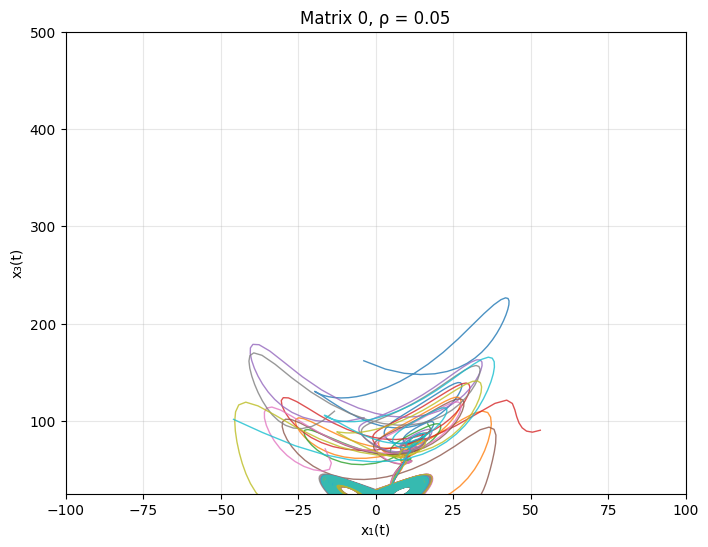

Loaded data shape: (10, 3, 5000)


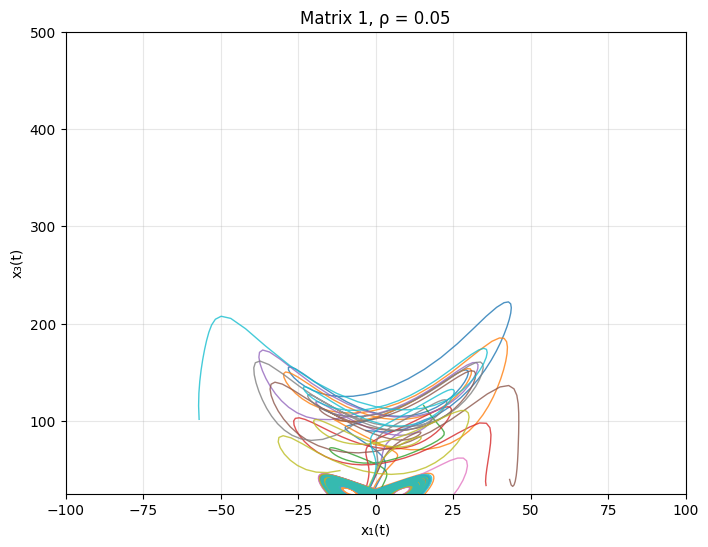

Loaded data shape: (10, 3, 5000)


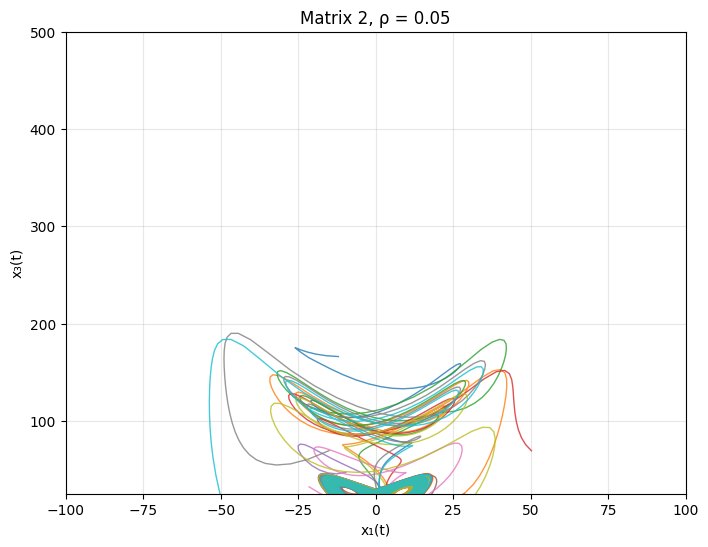

Loaded data shape: (10, 3, 5000)


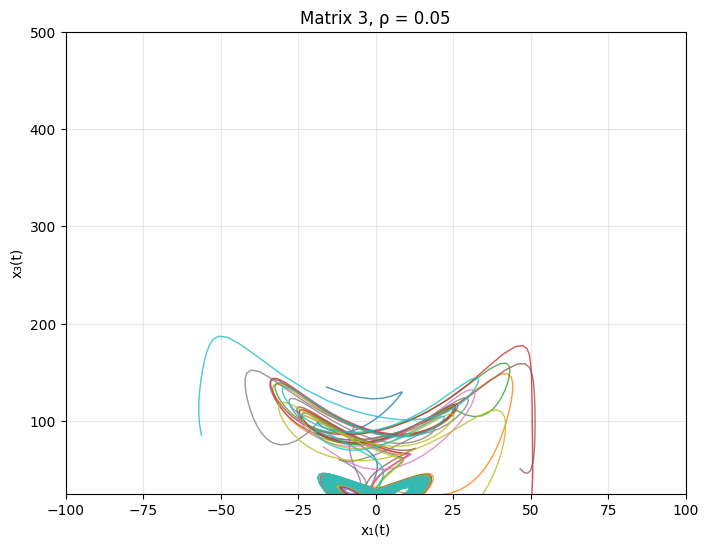

Loaded data shape: (10, 3, 5000)


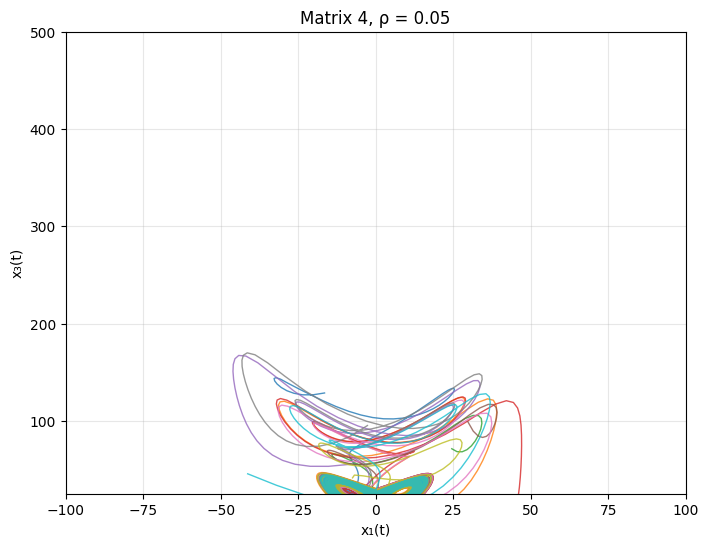

Loaded data shape: (10, 3, 5000)


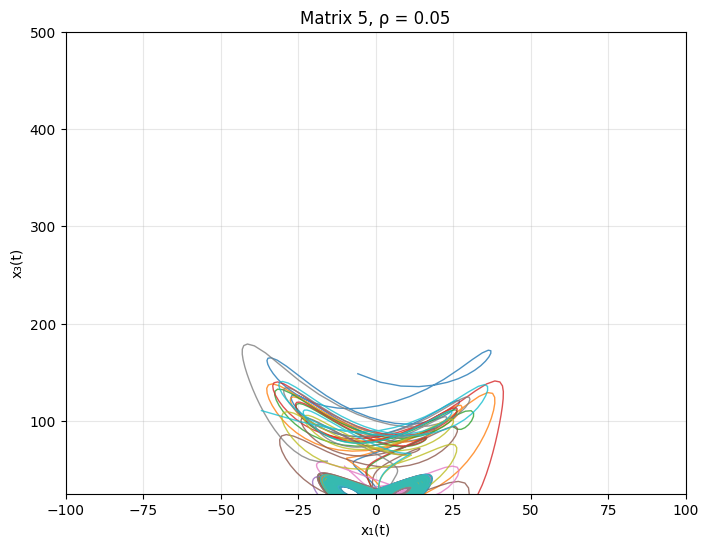

Loaded data shape: (10, 3, 5000)


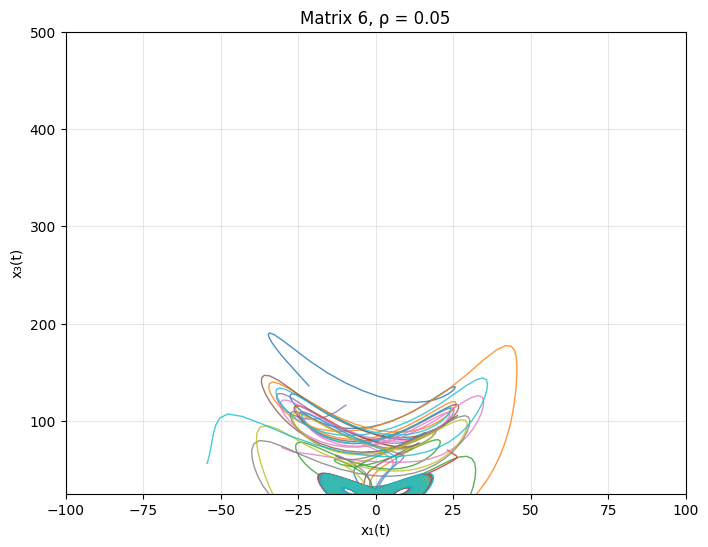

Loaded data shape: (10, 3, 5000)


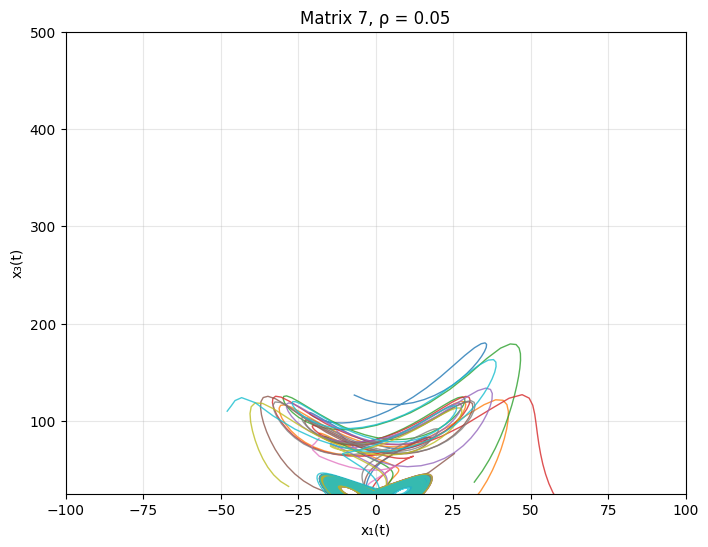

Loaded data shape: (10, 3, 5000)


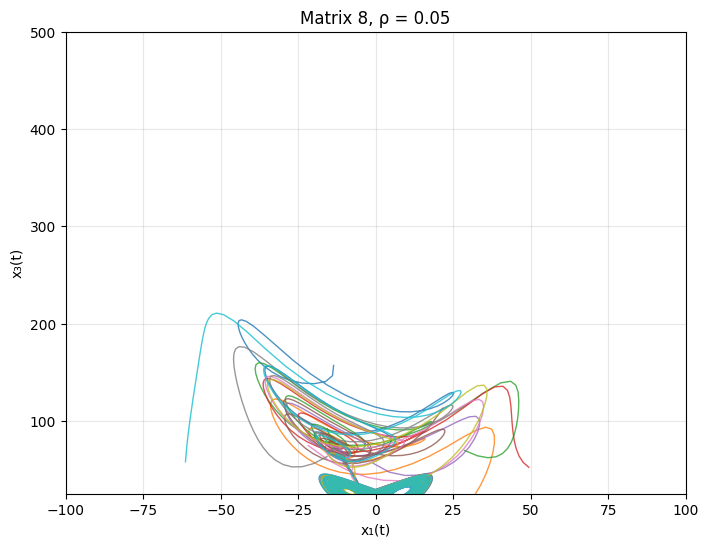

Loaded data shape: (10, 3, 5000)


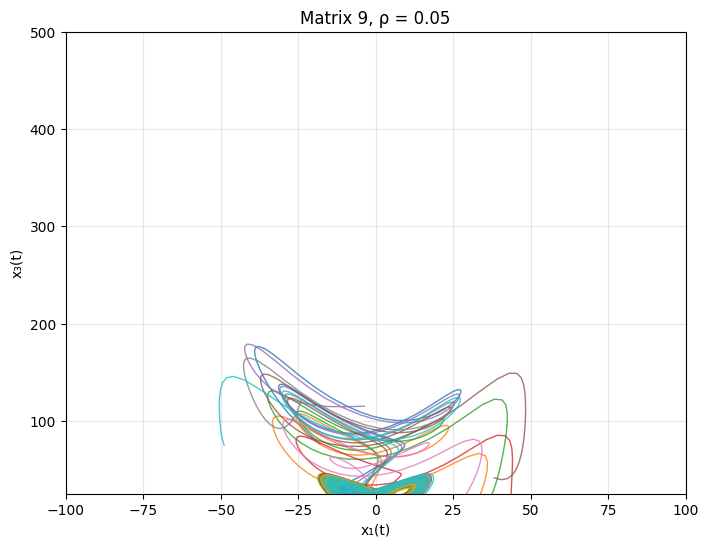

Loaded data shape: (10, 3, 5000)


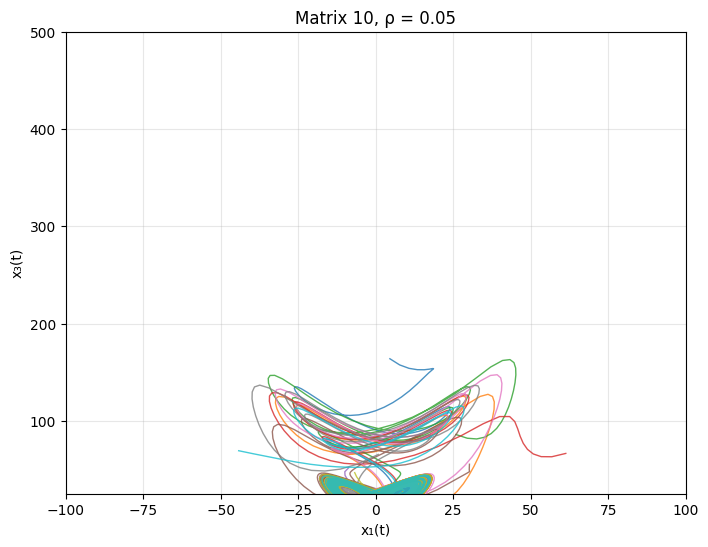

Loaded data shape: (10, 3, 5000)


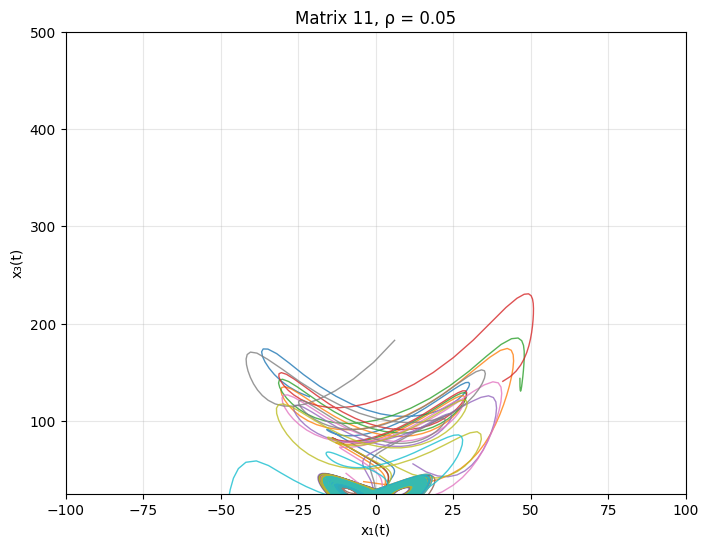

Loaded data shape: (10, 3, 5000)


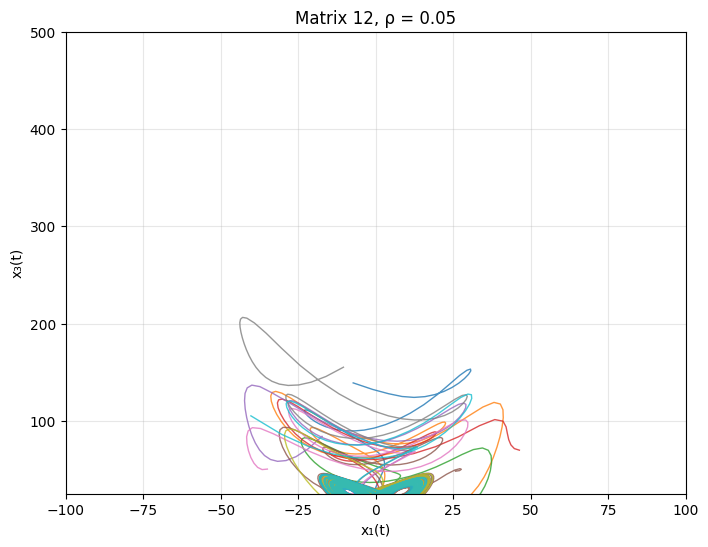

Loaded data shape: (10, 3, 5000)


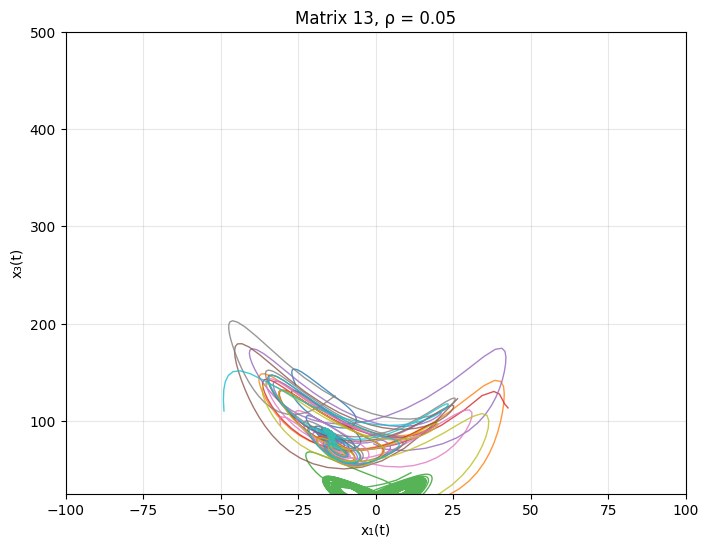

Loaded data shape: (10, 3, 5000)


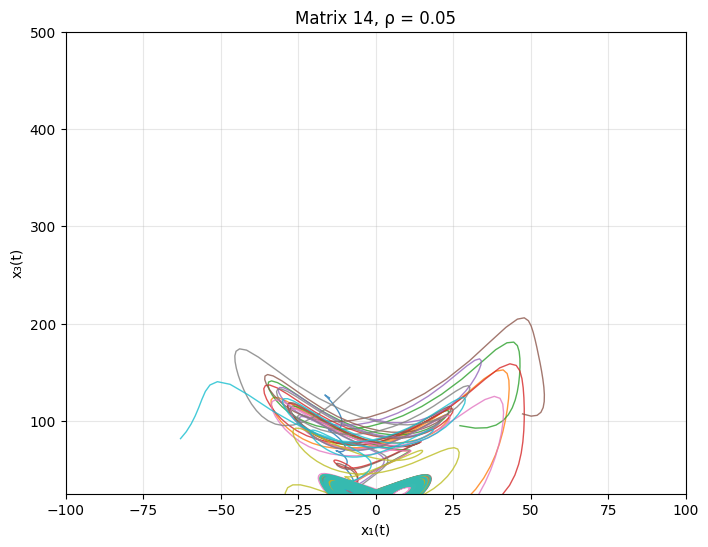

Loaded data shape: (10, 3, 5000)


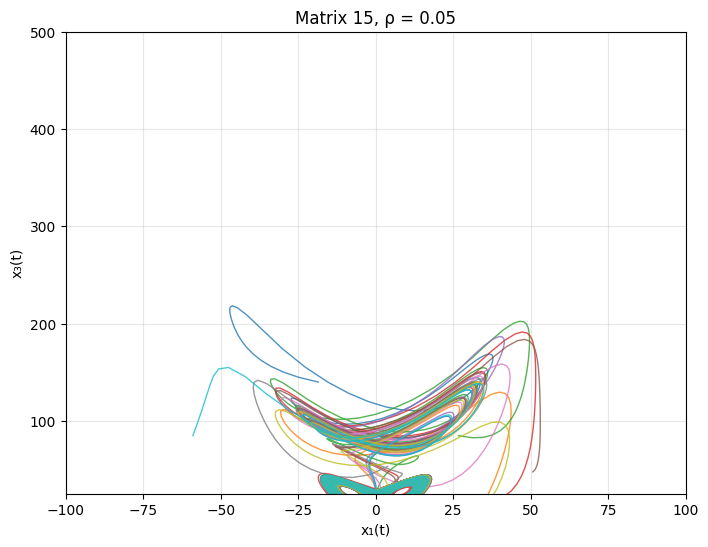

Loaded data shape: (10, 3, 5000)


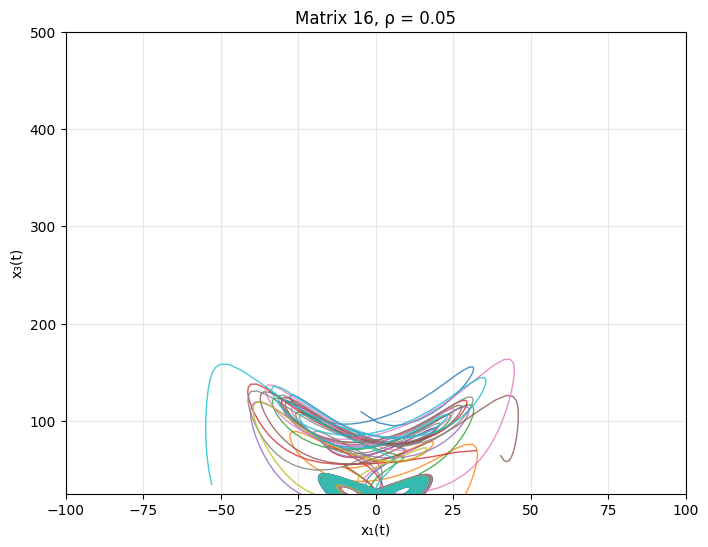

Loaded data shape: (10, 3, 5000)


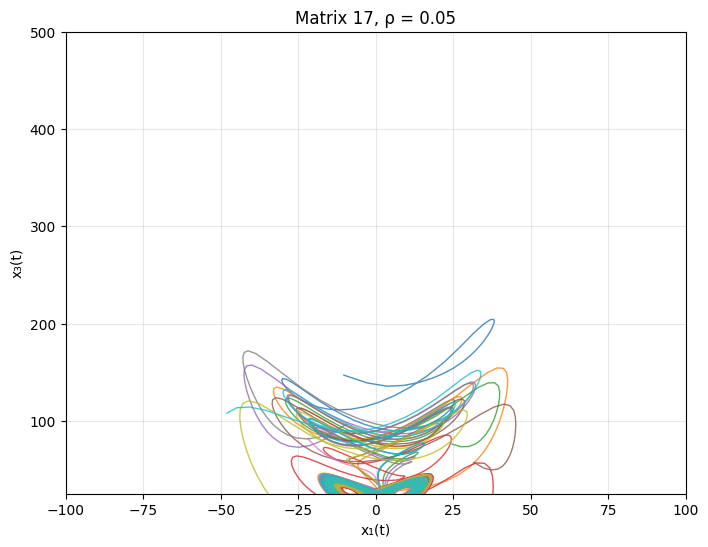

Loaded data shape: (10, 3, 5000)


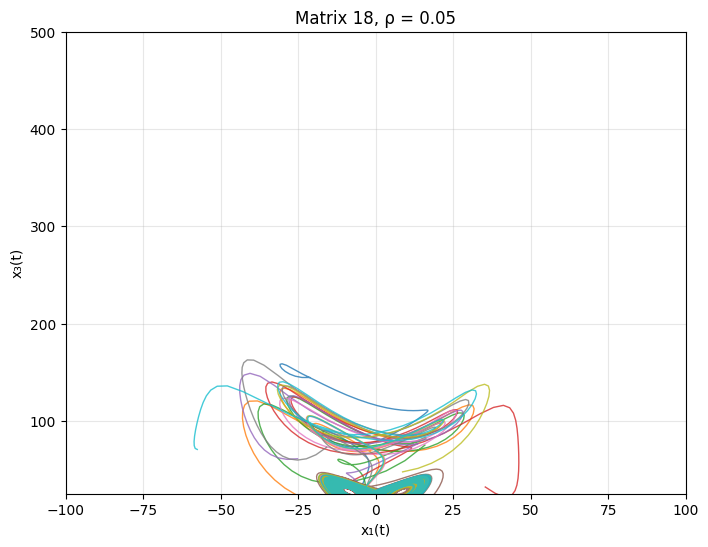

Loaded data shape: (10, 3, 5000)


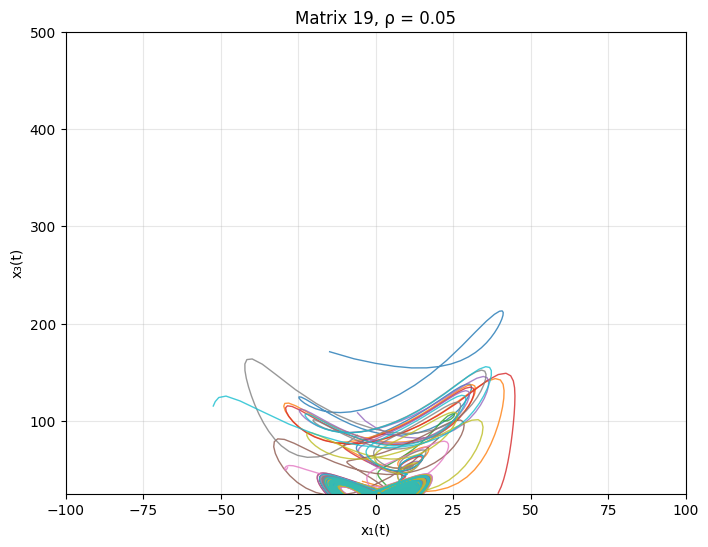

Loaded data shape: (10, 3, 5000)


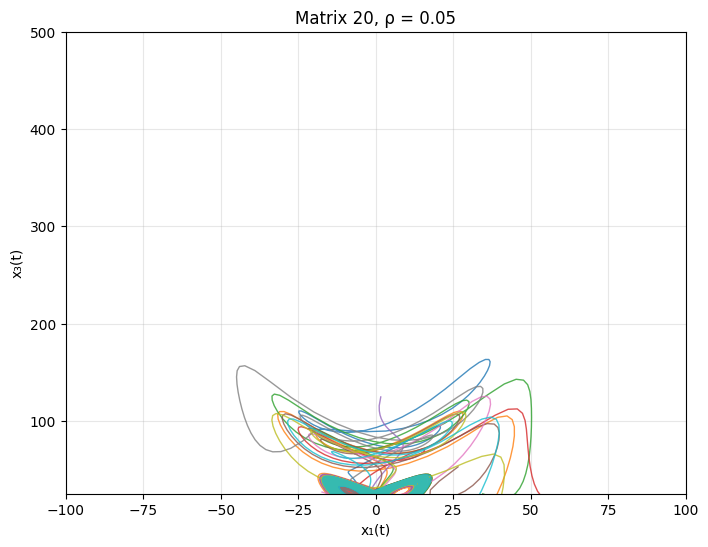

Loaded data shape: (10, 3, 5000)


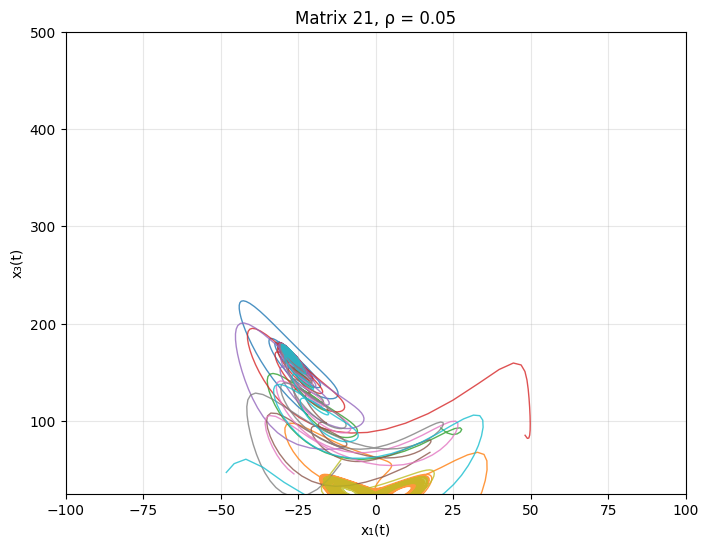

Loaded data shape: (10, 3, 5000)


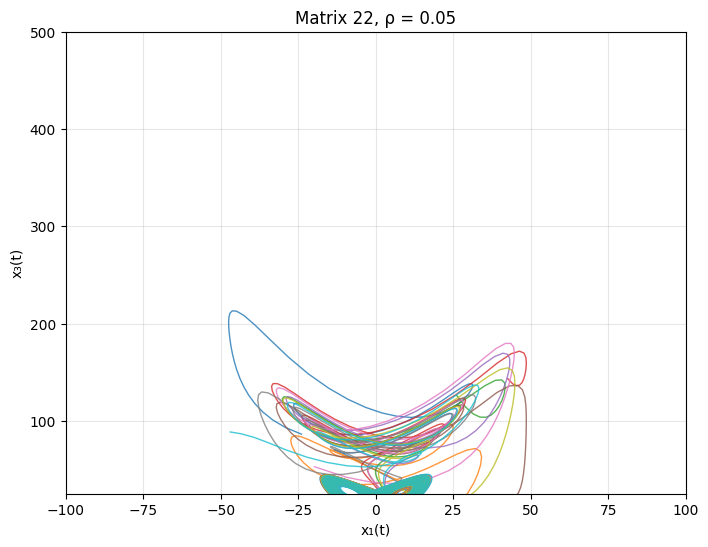

Loaded data shape: (10, 3, 5000)


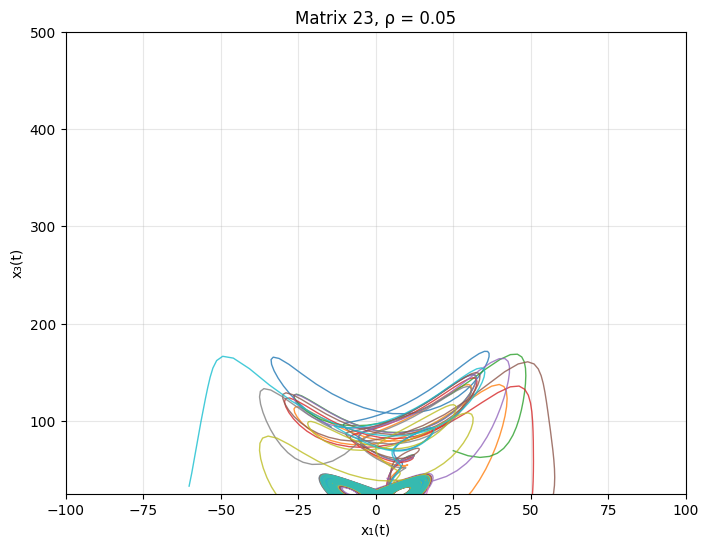

Loaded data shape: (10, 3, 5000)


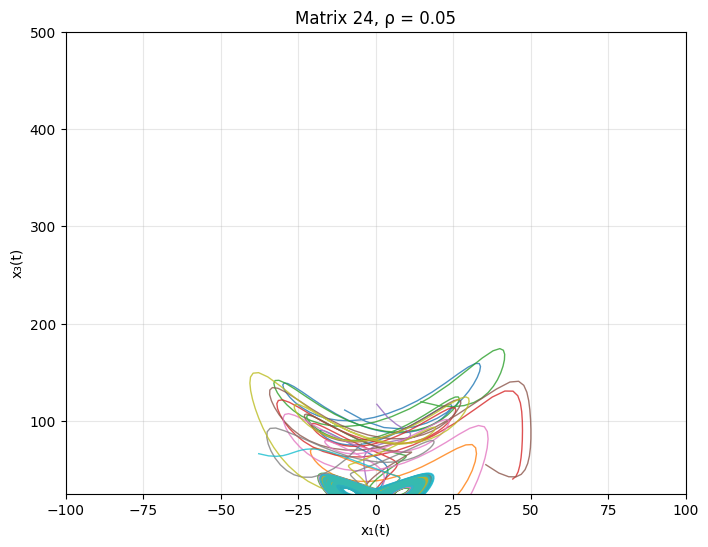

Loaded data shape: (10, 3, 5000)


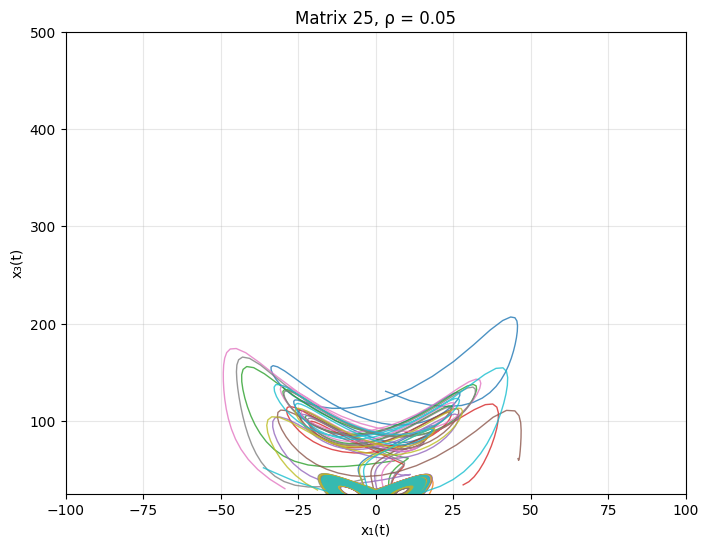

Loaded data shape: (10, 3, 5000)


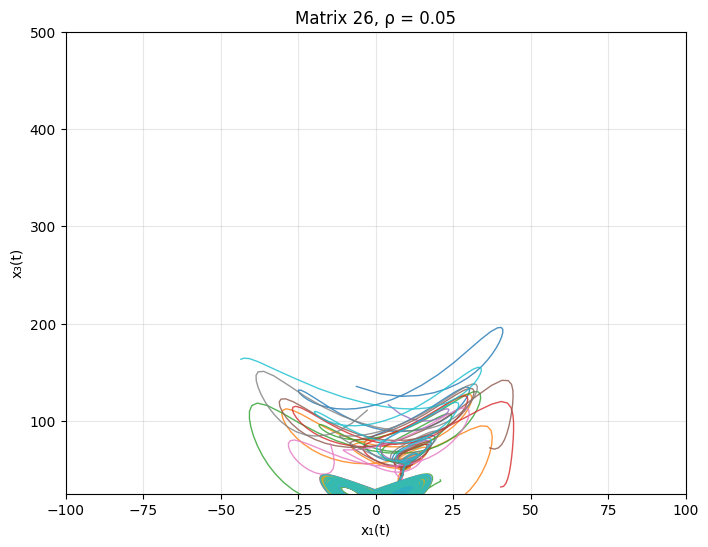

Loaded data shape: (10, 3, 5000)


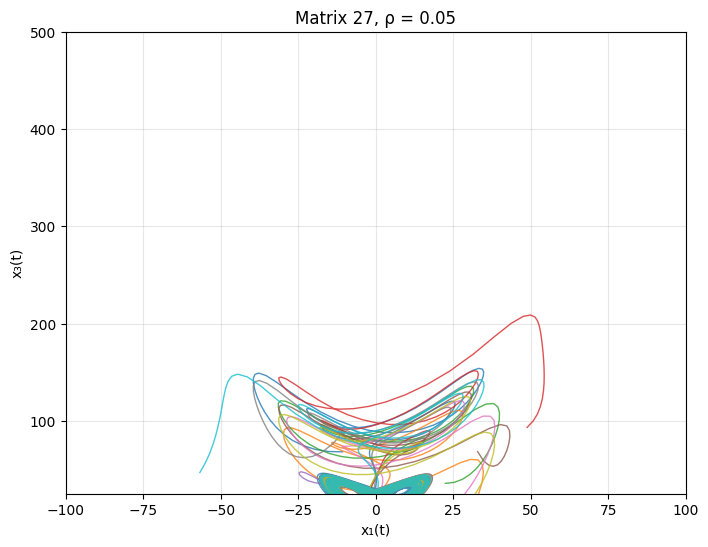

Loaded data shape: (10, 3, 5000)


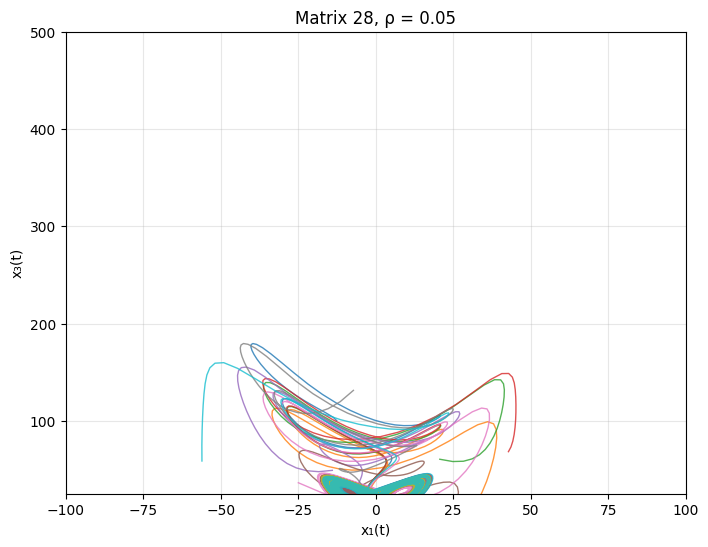

Loaded data shape: (10, 3, 5000)


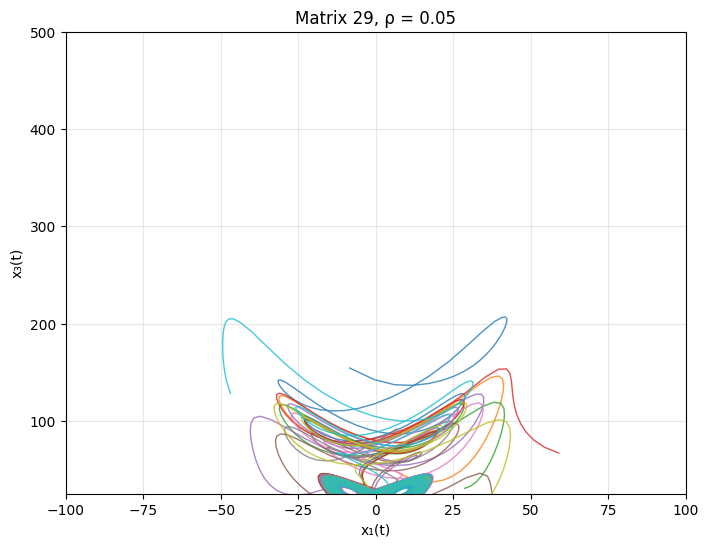

In [11]:
# Load and plot all 30 matrices for rho = 0 with custom y limits
rho_val = 0.05
sigma_val = 0.2
custom_ylim = [ 25, 500]
custom_xlim = [ -100, 100]


for M_label in range(30):
   load_and_plot_simple(M_label=M_label, rho_val=rho_val, sigma_val=sigma_val, 
                       ylim=custom_ylim, xlim = custom_xlim)

In [12]:
def load_and_plot_last_15sec(M_label, rho_val, sigma_val=0.2, xlim=[-40, 40], ylim=[-150, 150]):
    """Load saved data and plot only the last 15 seconds"""
    
    # Load the saved data
    u_pred = np.load(str('_u_pred_')+str('_M_label_')+str(M_label)+str('_rho_')+str(rho_val)+str('_sigma_')+str(sigma_val)+str('_Week7_.npy'), allow_pickle=True)
    
    # Calculate last 15 seconds
    dt = 0.01  # time step
    last_15sec_steps = int(15.0 / dt)  # 1500 time steps
    
    # Get only the last 1500 time steps
    u_pred_last15 = u_pred[:, :, -last_15sec_steps:]  # Shape: (10, 3, 1500)
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(10):  # 10 initial conditions
        x_coords = u_pred_last15[i, 0, :]  # x coordinates, last 15 sec
        z_coords = u_pred_last15[i, 2, :]  # z coordinates, last 15 sec
        ax.plot(x_coords, z_coords, color=colors[i], alpha=0.8, linewidth=1.0)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('x₁(t)')
    ax.set_ylabel('x₃(t)')
    ax.set_title(f'Matrix {M_label}, ρ = {rho_val} (Last 15 seconds)')
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.savefig(str('plot_last_15sec.pdf'),transparent=True,bbox_inches='tight')



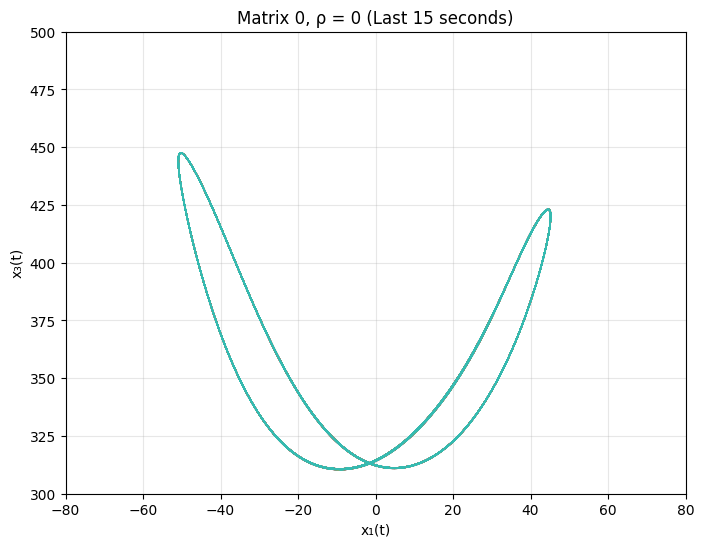

<Figure size 640x480 with 0 Axes>

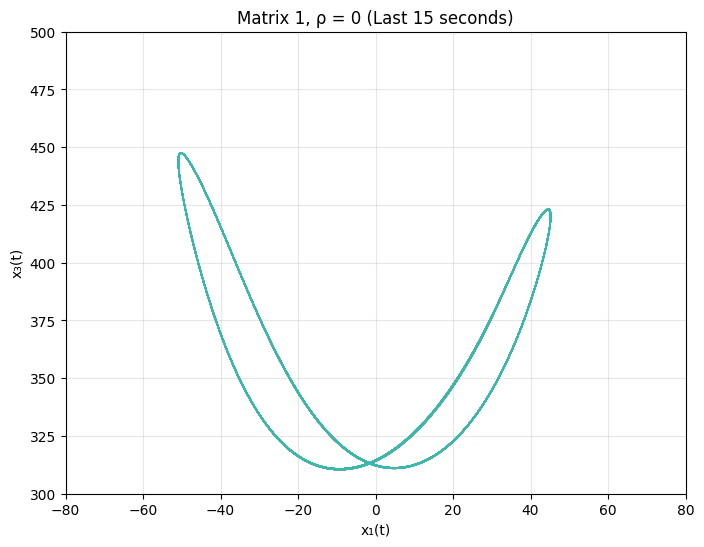

<Figure size 640x480 with 0 Axes>

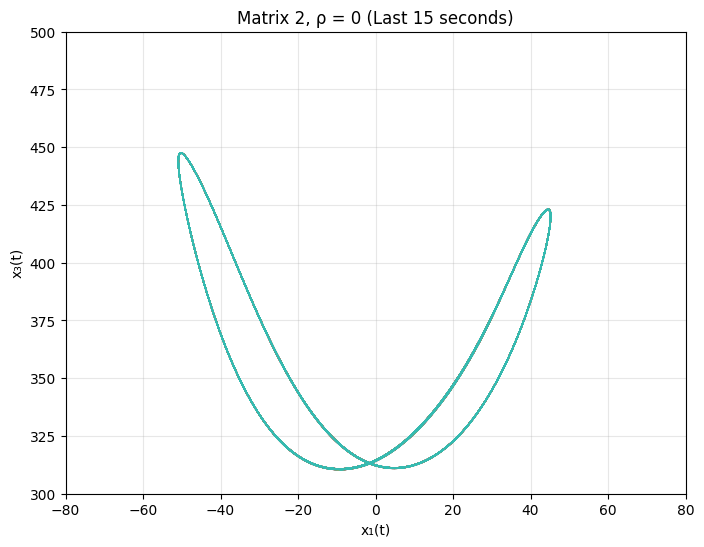

<Figure size 640x480 with 0 Axes>

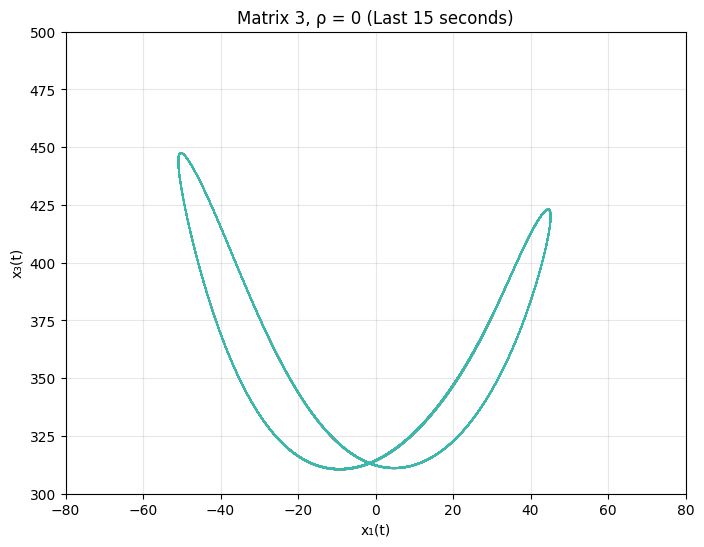

<Figure size 640x480 with 0 Axes>

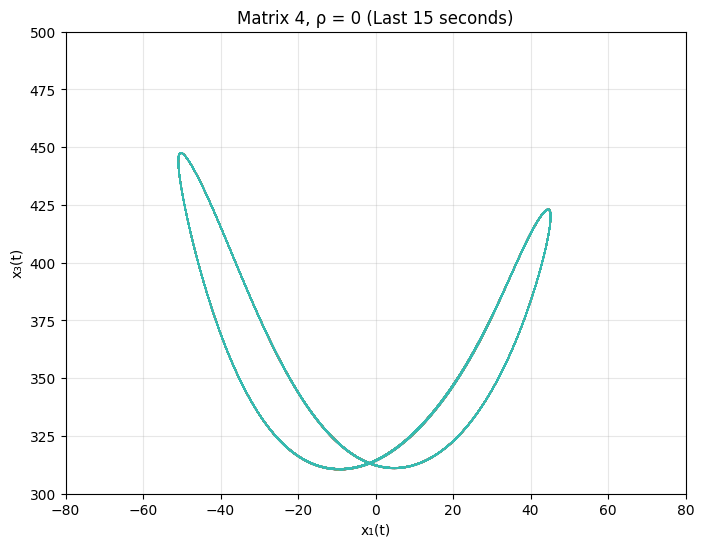

<Figure size 640x480 with 0 Axes>

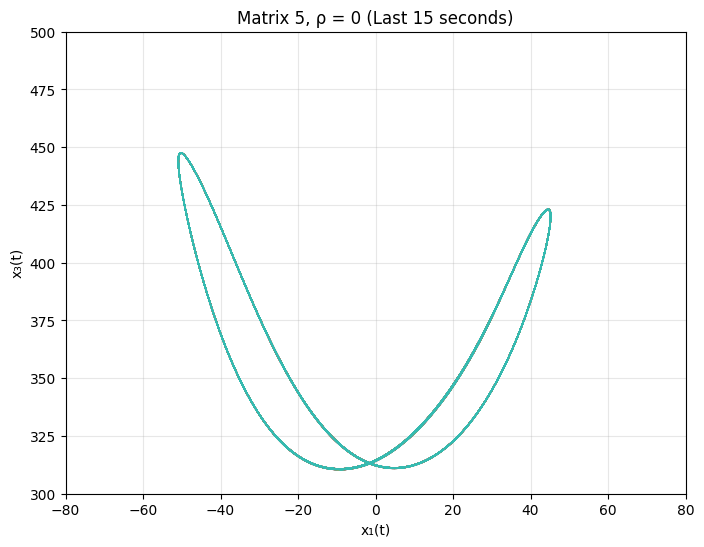

<Figure size 640x480 with 0 Axes>

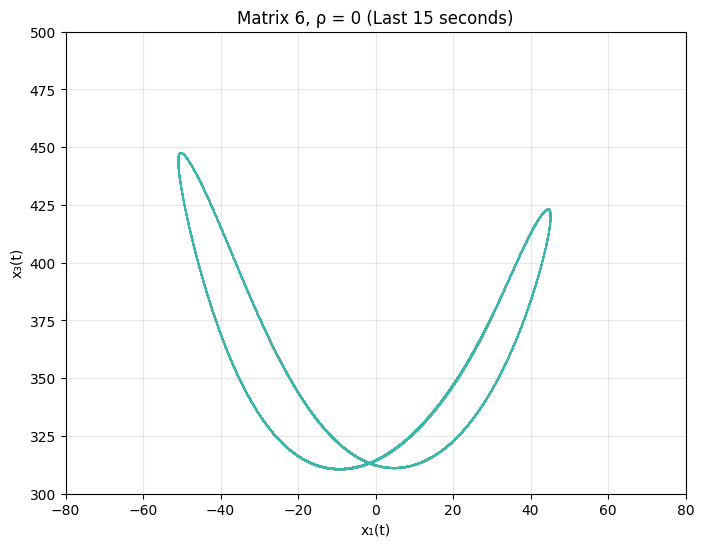

<Figure size 640x480 with 0 Axes>

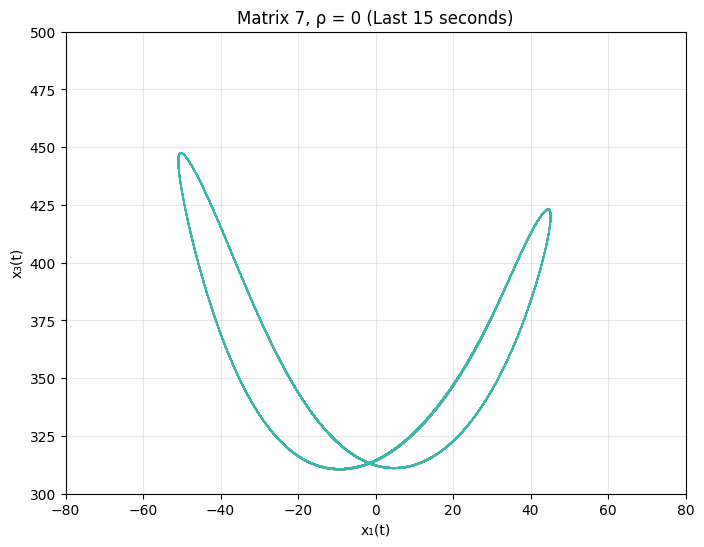

<Figure size 640x480 with 0 Axes>

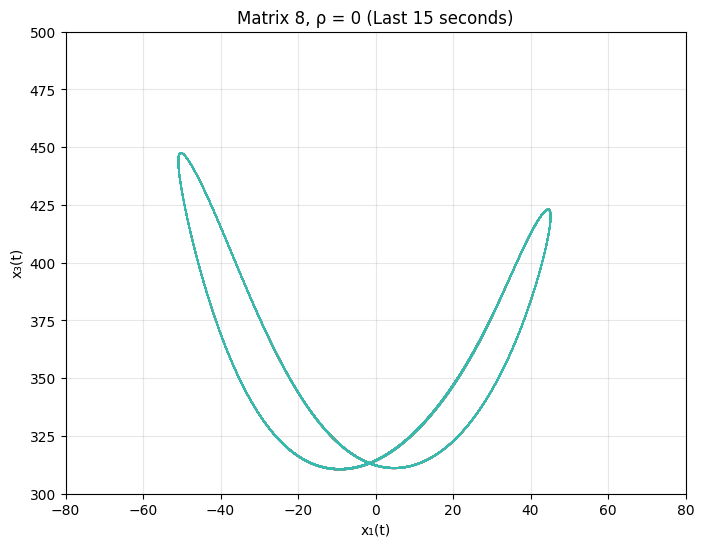

<Figure size 640x480 with 0 Axes>

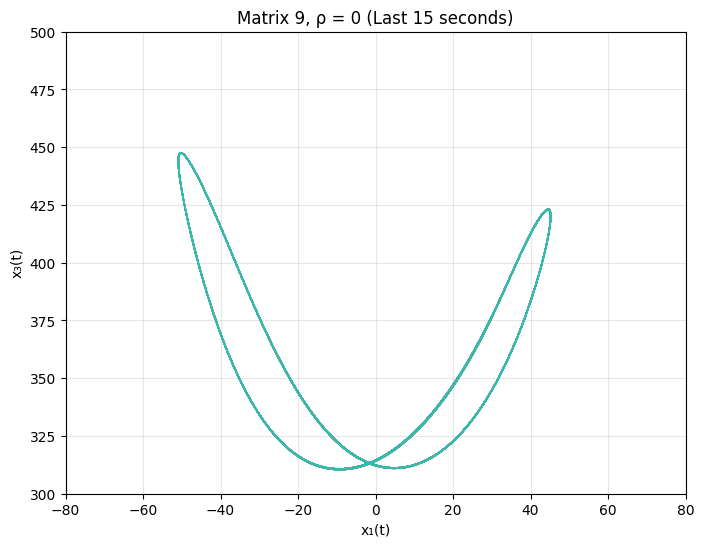

<Figure size 640x480 with 0 Axes>

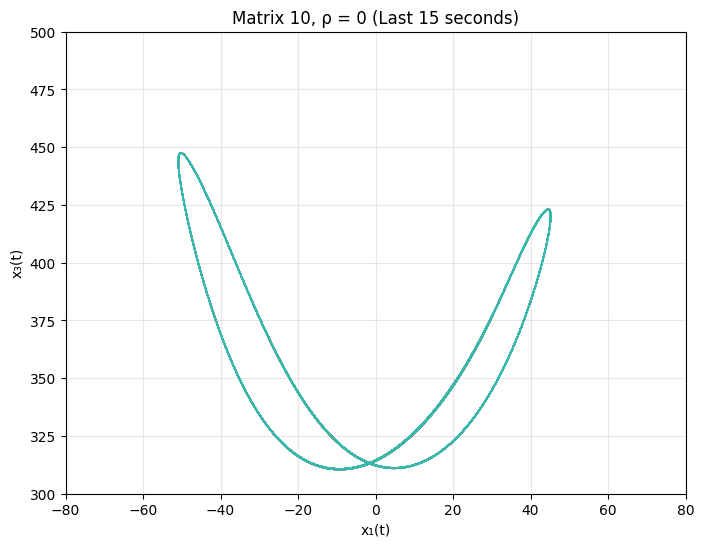

<Figure size 640x480 with 0 Axes>

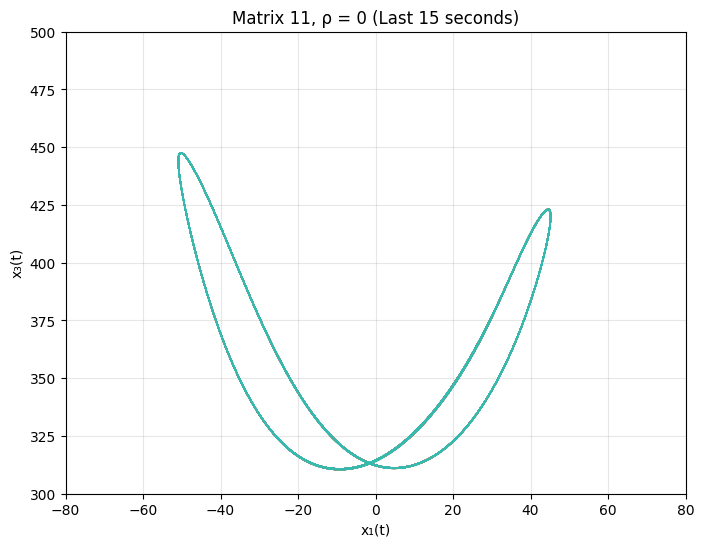

<Figure size 640x480 with 0 Axes>

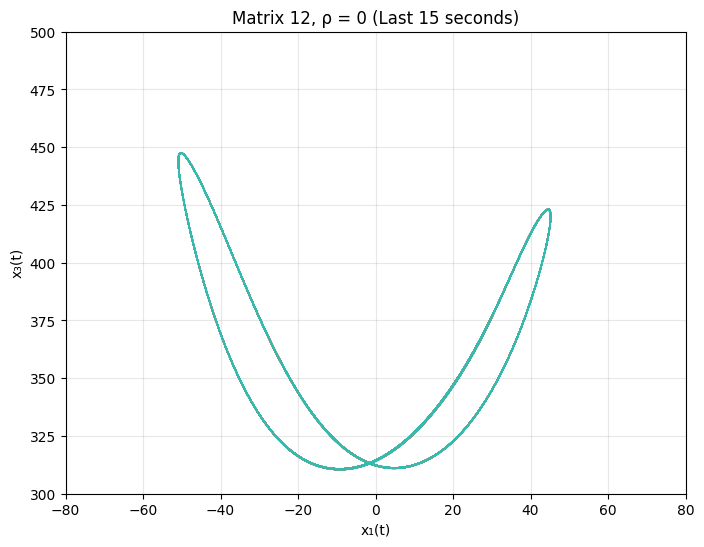

<Figure size 640x480 with 0 Axes>

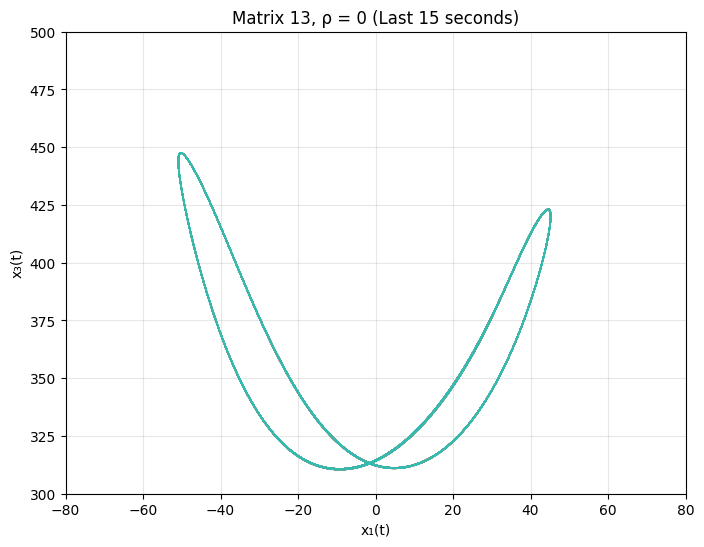

<Figure size 640x480 with 0 Axes>

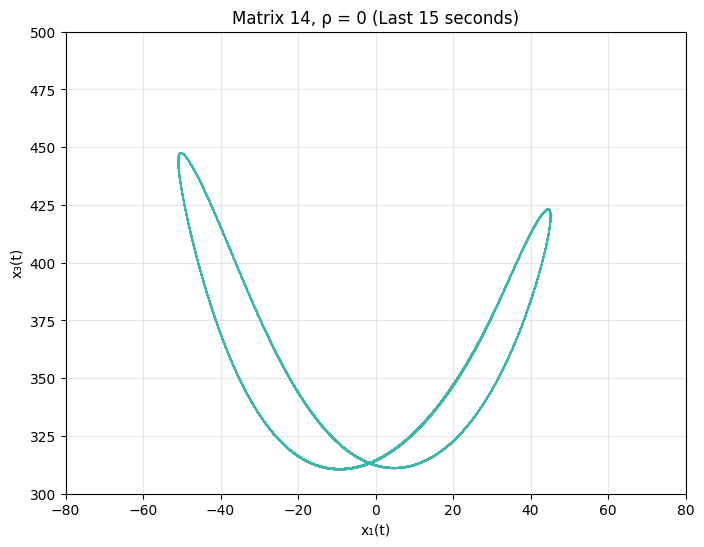

<Figure size 640x480 with 0 Axes>

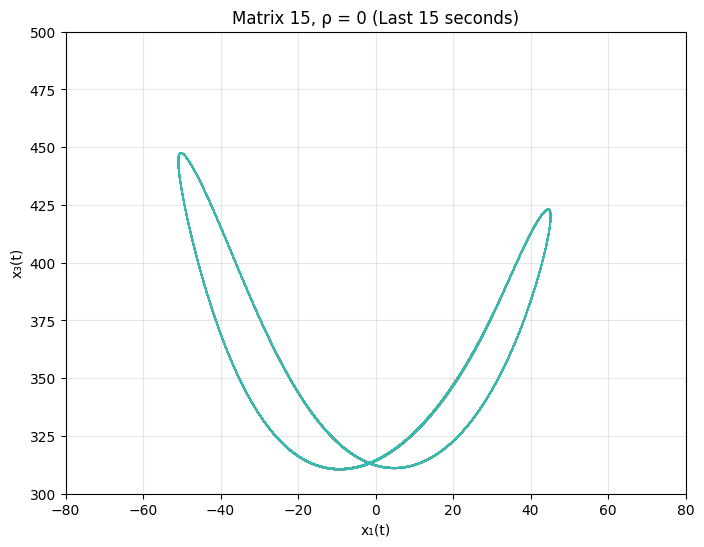

<Figure size 640x480 with 0 Axes>

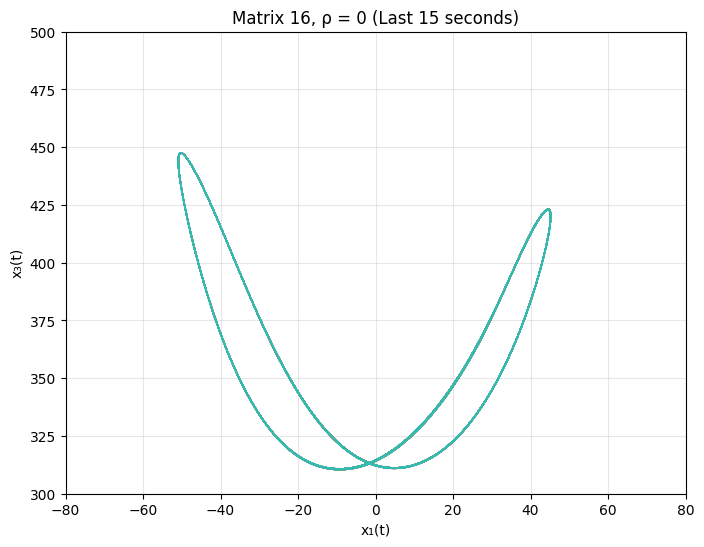

<Figure size 640x480 with 0 Axes>

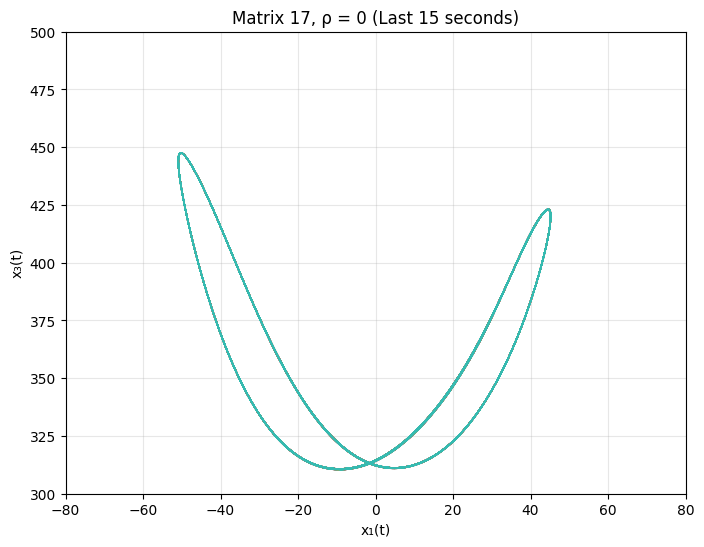

<Figure size 640x480 with 0 Axes>

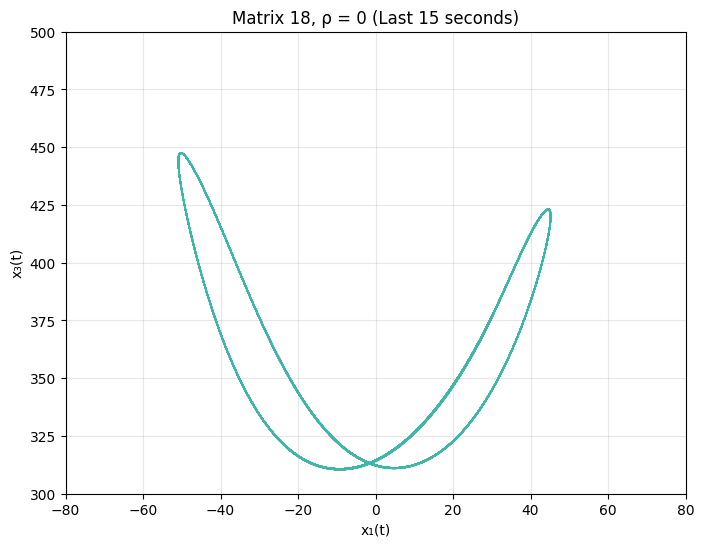

<Figure size 640x480 with 0 Axes>

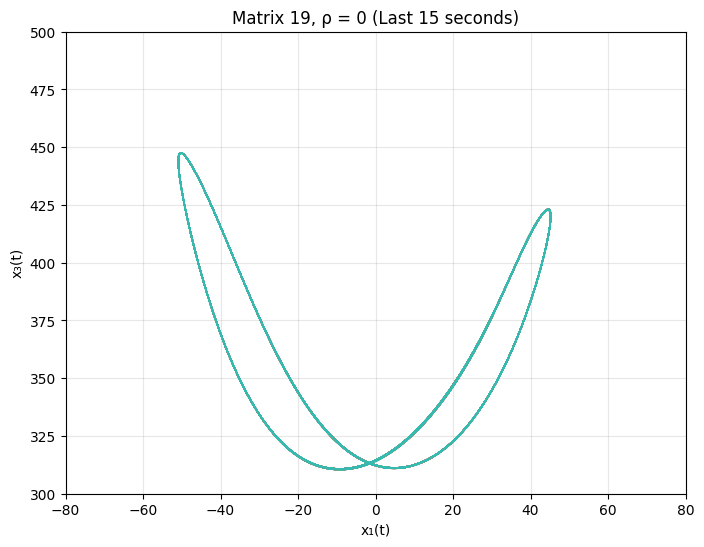

<Figure size 640x480 with 0 Axes>

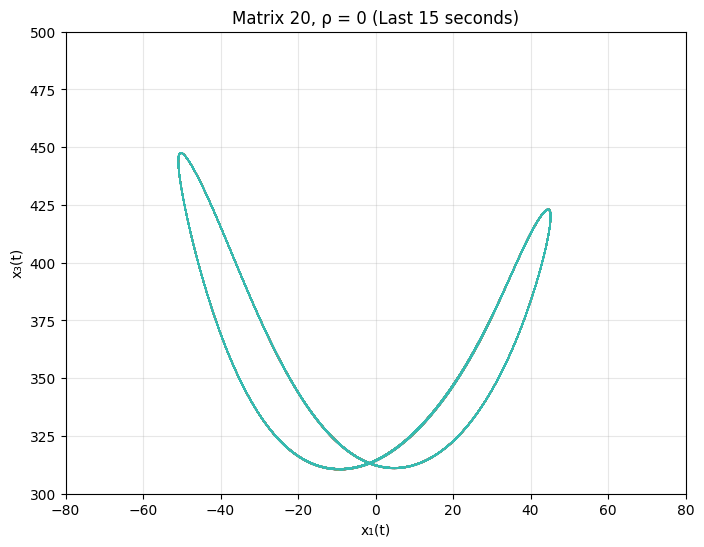

<Figure size 640x480 with 0 Axes>

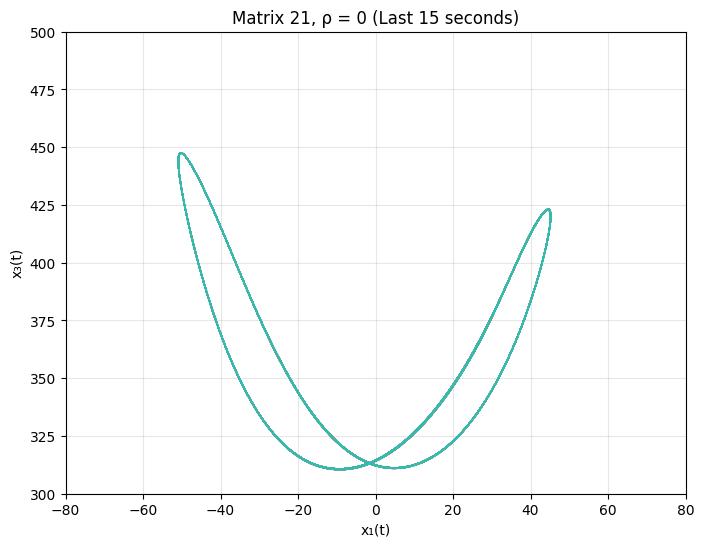

<Figure size 640x480 with 0 Axes>

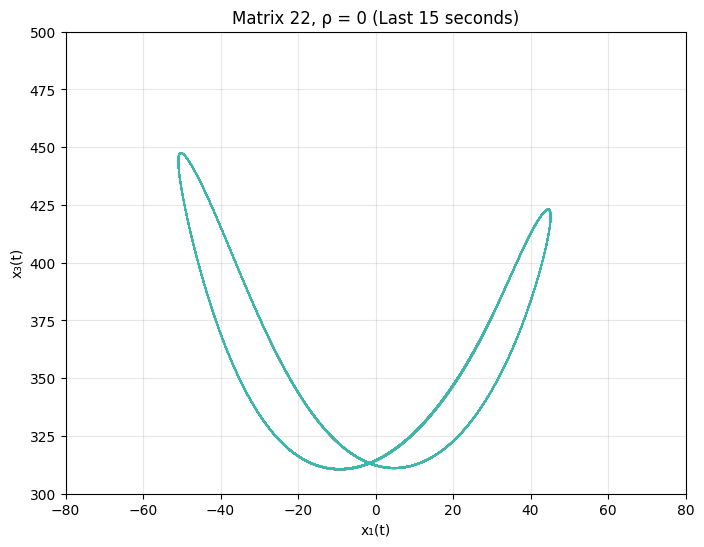

<Figure size 640x480 with 0 Axes>

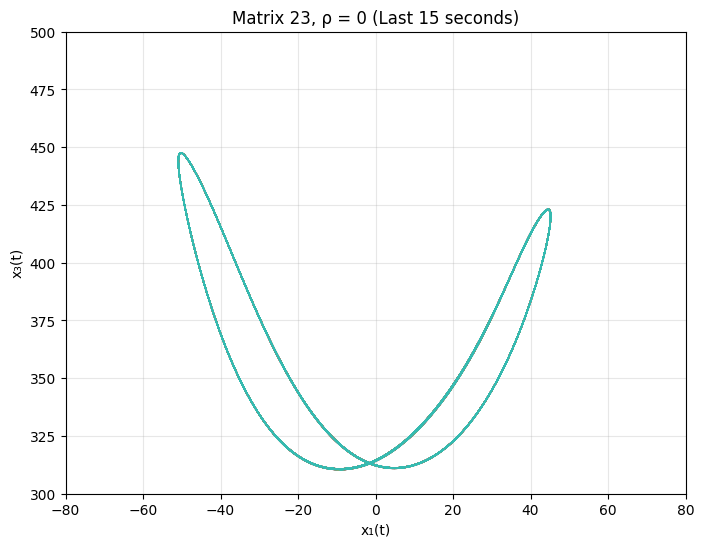

<Figure size 640x480 with 0 Axes>

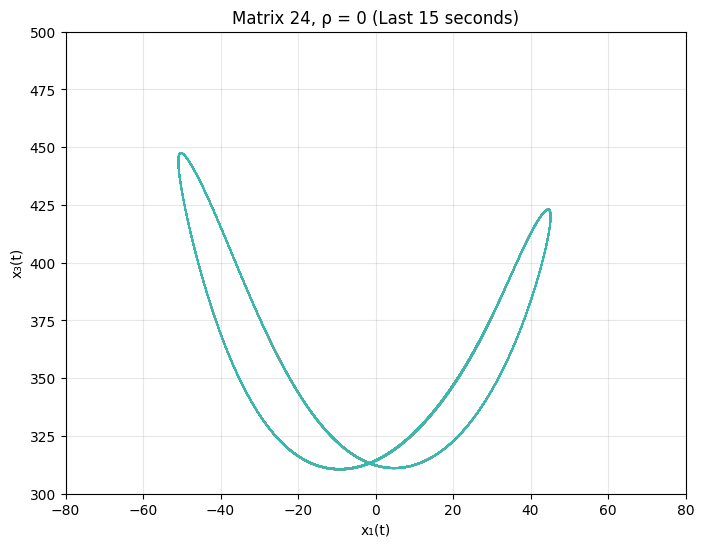

<Figure size 640x480 with 0 Axes>

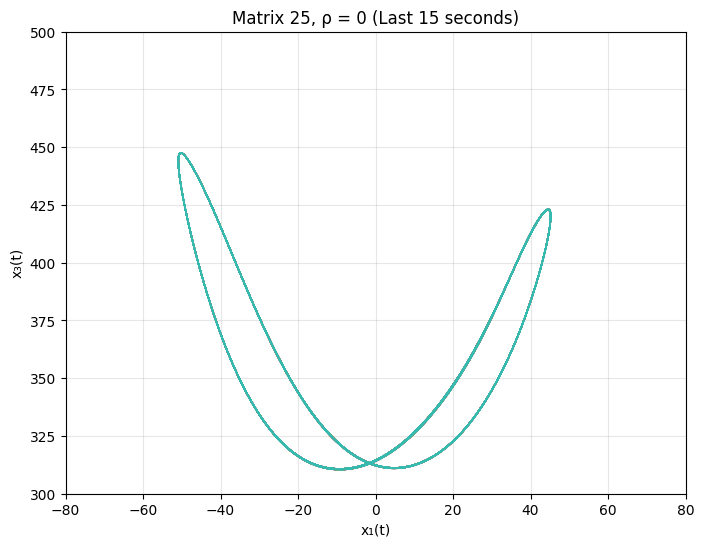

<Figure size 640x480 with 0 Axes>

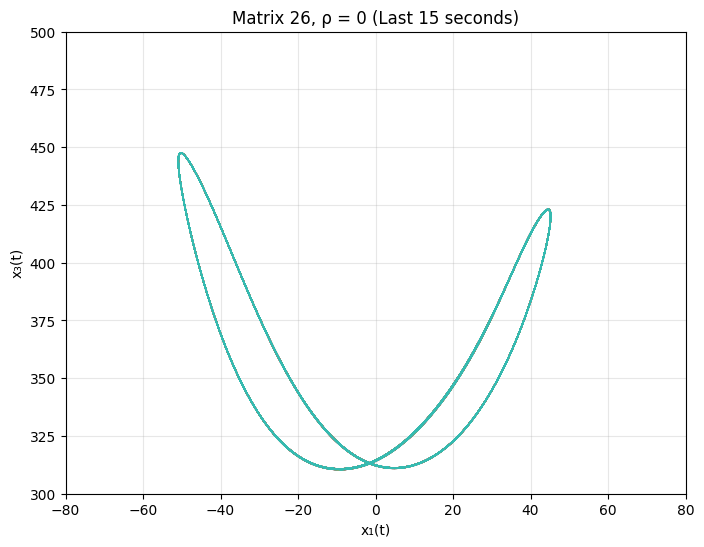

<Figure size 640x480 with 0 Axes>

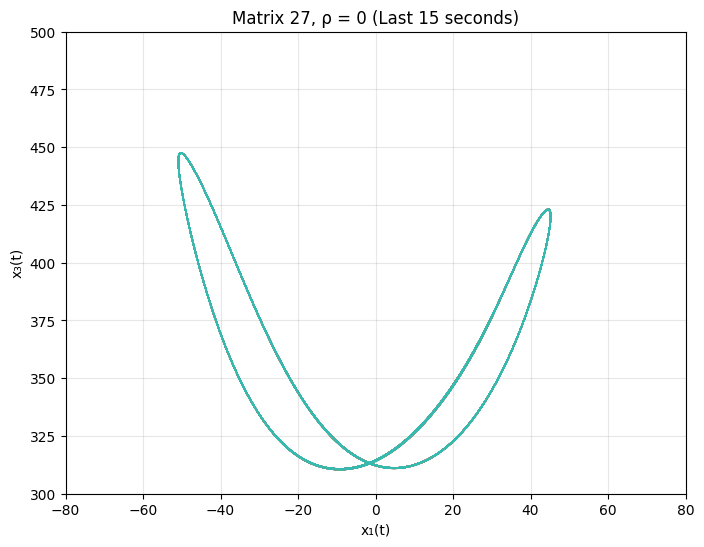

<Figure size 640x480 with 0 Axes>

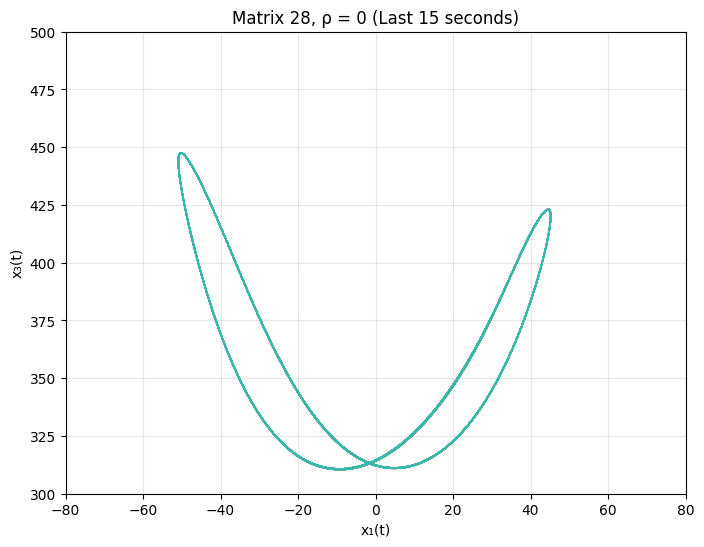

<Figure size 640x480 with 0 Axes>

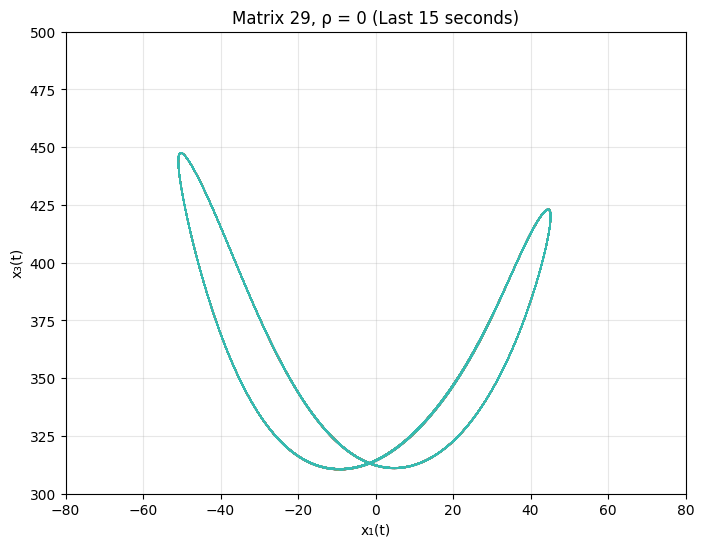

<Figure size 640x480 with 0 Axes>

In [21]:
# Load and plot all 30 matrices for rho = 0 with custom y limits
rho_val = 0
sigma_val = 0.2
custom_ylim = [ 300, 500]
custom_xlim = [ -80, 80]


for M_label in range(30):
   load_and_plot_last_15sec(M_label=M_label, rho_val=rho_val, sigma_val=sigma_val, 
                       ylim=custom_ylim, xlim = custom_xlim)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_attractor_on_axis(ax, u_pred, M_label, rho_val):
    """
    Plots the last 15 seconds of the Lorenz attractor reconstruction on a given matplotlib axis.
    """
    # --- Data Processing ---
    dt = 0.01  # time step
    last_15sec_steps = int(15.0 / dt)  # 1500 time steps

    # Ensure there are enough steps to plot, otherwise use all available steps
    num_available_steps = u_pred.shape[2]
    steps_to_plot = min(last_15sec_steps, num_available_steps)
    
    # Get the last N time steps
    u_pred_last15 = u_pred[:, :, -steps_to_plot:]  # Shape: (num_conditions, 3, steps_to_plot)

    # --- Plotting ---
    num_initial_conditions = u_pred_last15.shape[0]
    colors = plt.cm.viridis(np.linspace(0, 1, num_initial_conditions))

    for i in range(num_initial_conditions):
        x_coords = u_pred_last15[i, 0, :]  # x coordinates
        z_coords = u_pred_last15[i, 2, :]  # z coordinates
        ax.plot(x_coords, z_coords, color=colors[i], alpha=0.7, linewidth=0.8)

def generate_grid_plot(M_labels, rho_values, sigma_val, xlim, ylim, save_path="lorenz_attractor_grid.pdf"):
    """
    Generates and saves a grid of plots for different M matrices and spectral radii.
    
    Args:
        M_labels (list or range): A list of M matrix labels (e.g., range(30)).
        rho_values (list): A list of spectral radius values.
        sigma_val (float): The sigma value used in the experiment.
        xlim (tuple): The x-axis limits for all plots (e.g., [-80, 80]).
        ylim (tuple): The y-axis limits for all plots (e.g., [-100, 150]).
        save_path (str): The filename to save the final plot.
    """
    num_rows = len(M_labels)
    num_cols = len(rho_values)

    # Adjust figsize for better readability. You may need to tweak these values.
    # A good starting point is ~2.5 inches per column and ~2 inches per row.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2), sharex=True, sharey=True)

    print("Generating grid plot... This may take a moment.")

    for row, M_label in enumerate(M_labels):
        for col, rho_val in enumerate(rho_values):
            ax = axes[row, col]
            
            # Construct the filename based on your naming convention
            filename = f"_u_pred__M_label_{M_label}_rho_{rho_val}_sigma_{sigma_val}_Week7_.npy"

            if os.path.exists(filename):
                try:
                    # Load the saved data
                    u_pred = np.load(filename, allow_pickle=True)
                    plot_attractor_on_axis(ax, u_pred, M_label, rho_val)
                except Exception as e:
                    ax.text(0.5, 0.5, 'Error\nloading', ha='center', va='center', fontsize=8, color='red')
                    print(f"Could not load or plot {filename}: {e}")
            else:
                # If a file is missing, mark the subplot
                ax.text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=8)
                ax.set_facecolor('lightgray')
                print(f"Warning: File not found - {filename}")

            # --- Formatting ---
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.grid(True, linestyle='--', alpha=0.3)
            
            # Add titles for the top row (columns)
            if row == 0:
                ax.set_title(f"$\\rho = {rho_val}$", fontsize=12)

            # Add labels for the first column (rows)
            if col == 0:
                ax.set_ylabel(f"M = {M_label}", fontsize=12, labelpad=10)

    # Set master labels for the entire figure
    fig.text(0.5, 0.08, 'x₁(t)', ha='center', va='center', fontsize=16)
    fig.text(0.06, 0.5, 'x₃(t)', ha='center', va='center', rotation='vertical', fontsize=16)
    
    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(rect=[0.08, 0.1, 1, 0.98]) # rect=[left, bottom, right, top]

    # Save the final figure
    print(f"\nSaving figure to {save_path}...")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Done!")



In [18]:
generate_grid_plot

<function __main__.generate_grid_plot(M_labels, rho_values, sigma_val, xlim, ylim, save_path='lorenz_attractor_grid.pdf')>

Generating grid plot... This may take a moment.
Could not load or plot _u_pred__M_label_1_rho_0.3_sigma_0.2_Week7_.npy: tuple index out of range

Saving figure to lorenz_reconstruction_grid.pdf...


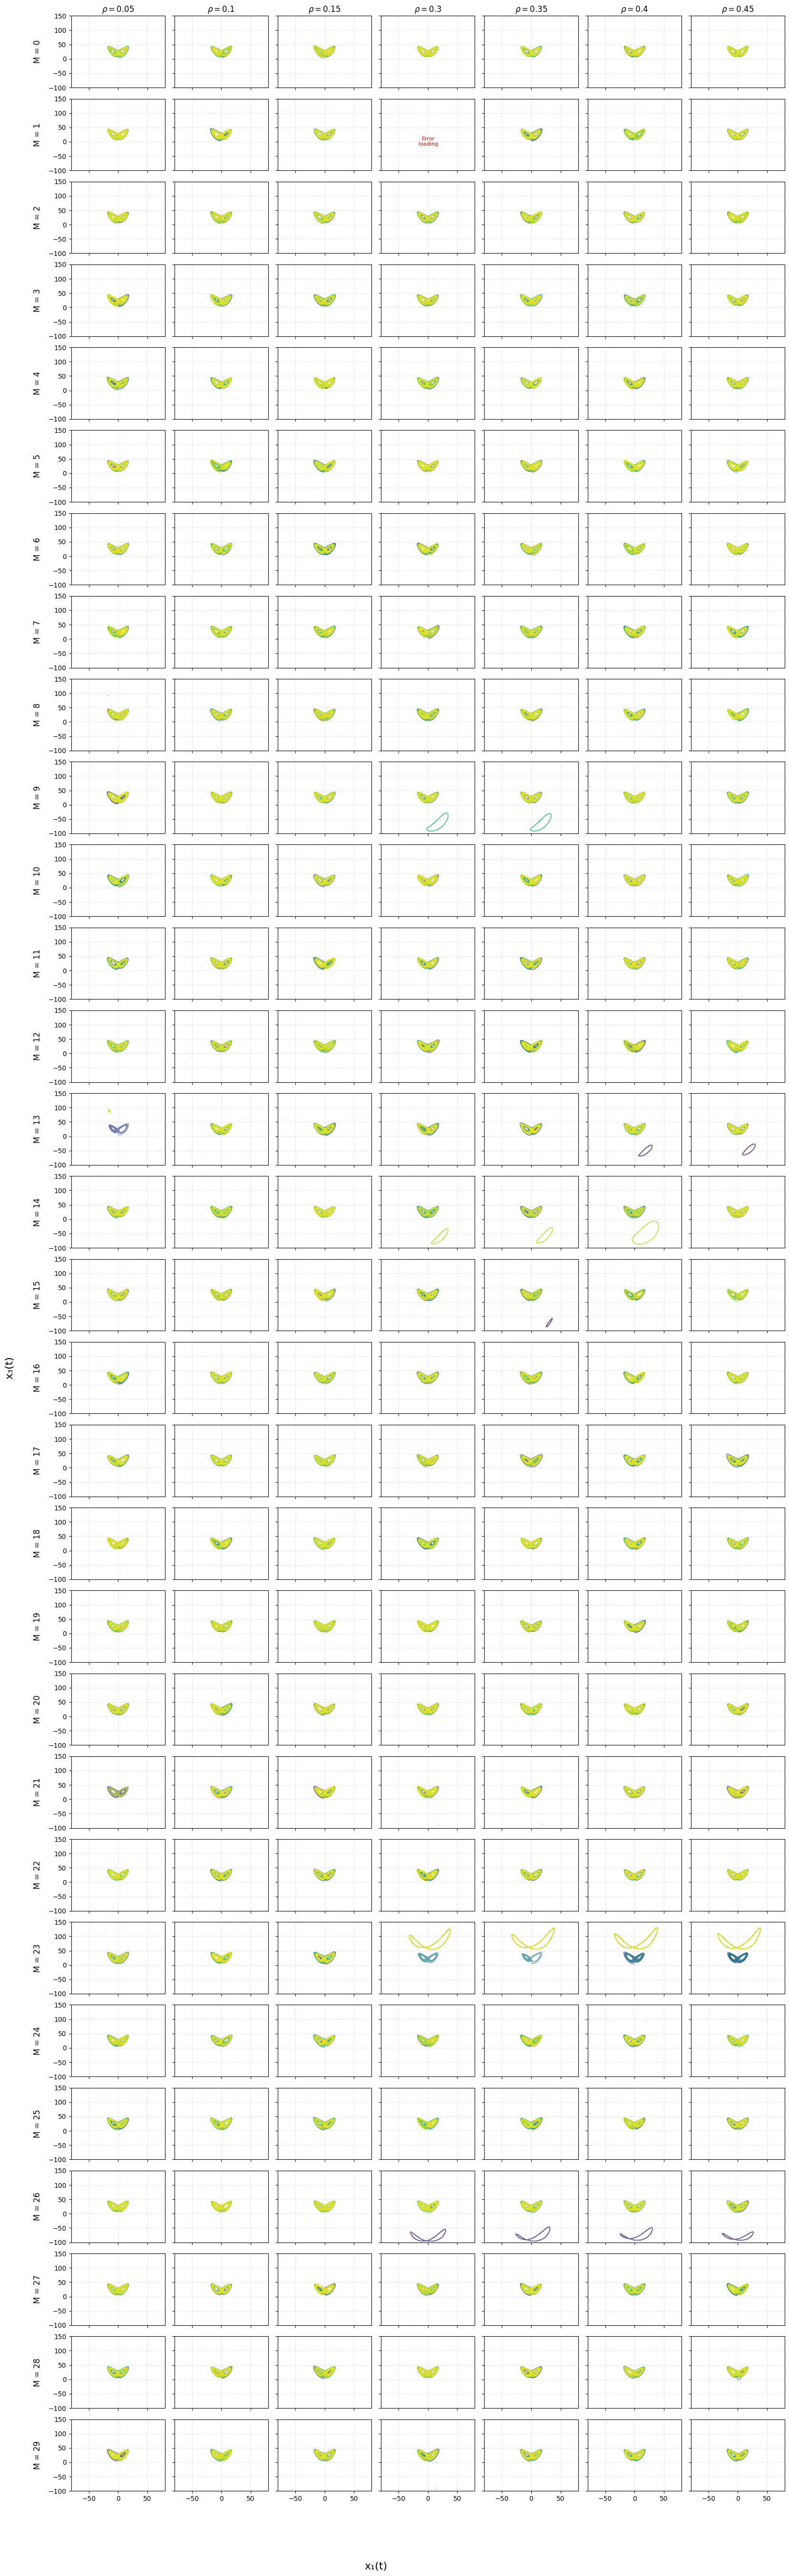

Done!


In [16]:
if __name__ == "__main__":
    # --- Parameters for the Grid Plot ---
    
    # 1. Define the M matrix labels you want to plot
    M_LABELS_TO_PLOT = range(30)  # Creates a range from 0 to 29

    # 2. Define the exact rho values used in your experiments
    RHO_VALUES_TO_PLOT = [0.05, 0.1, 0.15, 0.3, 0.35, 0.4, 0.45]

    # 3. Define the constant sigma value
    SIGMA_VALUE = 0.2

    # 4. Set the axis limits to be consistent across all plots
    CUSTOM_XLIM = [-80, 80]
    CUSTOM_YLIM = [-100, 150]

    # 5. Call the function to generate and save the grid
    generate_grid_plot(
        M_labels=M_LABELS_TO_PLOT,
        rho_values=RHO_VALUES_TO_PLOT,
        sigma_val=SIGMA_VALUE,
        xlim=CUSTOM_XLIM,
        ylim=CUSTOM_YLIM,
        save_path="lorenz_reconstruction_grid.pdf"
    )